In [7]:
!pip install numpy torch scikit-learn pennylane matplotlib tabulate seaborn umap-learn
!pip install --upgrade ipywidgets jupyter

In [88]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 9

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Optional, Tuple, Dict
import pickle
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import logging

# Set logging to WARNING to reduce verbosity
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# ---------- Utility Functions ----------

def tensor_to_event_list(tensor: np.ndarray) -> List[np.ndarray]:
    """Convert a 3D tensor (neurons, time bins, events) to a list of event matrices."""
    if tensor.ndim != 3:
        raise ValueError(f"Expected 3D tensor, got shape {tensor.shape}")
    return [tensor[:, :, e] for e in range(tensor.shape[2])]

def map_classes_to_012(y: np.ndarray, classes_sorted: Optional[List[int]] = None) -> np.ndarray:
    """Remap class labels to 0,1,2 based on sorted unique classes."""
    y = np.asarray(y)
    if classes_sorted is None:
        classes_sorted = sorted(np.unique(y))
    remap = {c: i for i, c in enumerate(classes_sorted)}
    return np.array([remap[c] for c in y], dtype=np.int32)

def summarize(metrics: List[float]) -> Tuple[float, float]:
    """Compute mean and standard deviation of a list of metrics."""
    return float(np.mean(metrics)), float(np.std(metrics))

def bootstrap_ci_metric(y_true: np.ndarray, y_pred: np.ndarray, metric_fn, B: int = 5000, 
                       seed: int = 0, alpha: float = 0.05) -> Tuple[float, float]:
    """Compute bootstrap confidence intervals for a given metric."""
    rng = np.random.RandomState(seed)
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if len(y_true) == 0 or len(y_pred) == 0:
        return 0.0, 0.0
    n = len(y_true)
    boots = []
    for _ in range(B):
        idx = rng.randint(0, n, size=n)
        boots.append(metric_fn(y_true[idx], y_pred[idx]))
    boots = np.sort(boots)
    lo = boots[int((alpha / 2) * B)]
    hi = boots[int((1 - alpha / 2) * B)]
    return lo, hi

def permutation_test_baseline(X_pfc: Optional[List[np.ndarray]], X_hpc: Optional[List[np.ndarray]], 
                             y: np.ndarray, n_pcs_pfc: int, n_pcs_hpc: int, clf_name: str, 
                             n_splits: int = 3, n_perms: int = 100, random_state: int = 0) -> Tuple[float, float]:
    """Perform permutation test to assess classifier significance."""
    y = np.asarray(y)
    n_samples = len(y)
    splitter = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    accs_real = []
    accs_perm = []
    
    classifiers = {
        "LR": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=random_state),
        "LinSVM": SVC(kernel='linear', C=1.0, tol=1e-3, class_weight='balanced', decision_function_shape='ovr', random_state=random_state),
        "RBF_SVM": SVC(kernel='rbf', C=1.0, gamma='auto', tol=1e-3, class_weight='balanced', decision_function_shape='ovr', random_state=random_state),
        "RF": RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, class_weight='balanced', random_state=random_state)
    }
    clf = classifiers.get(clf_name, classifiers["LR"])
    
    for tr, te in splitter.split(np.arange(n_samples), y):
        if len(te) < 3 or len(tr) < 10:
            continue
        apca = AreaPCA(n_pcs_pfc, n_pcs_hpc).fit(
            [X_pfc[i] for i in tr] if X_pfc is not None else None,
            [X_hpc[i] for i in tr] if X_hpc is not None else None
        )
        Xtr = apca.transform(
            [X_pfc[i] for i in tr] if X_pfc is not None else None,
            [X_hpc[i] for i in tr] if X_hpc is not None else None
        )
        Xte = apca.transform(
            [X_pfc[i] for i in te] if X_pfc is not None else None,
            [X_hpc[i] for i in te] if X_hpc is not None else None
        )
        Xtr += np.random.normal(0, 1e-6, Xtr.shape)  # Add jitter
        Xte += np.random.normal(0, 1e-6, Xte.shape)
        clf.fit(Xtr, y[tr])
        accs_real.append(accuracy_score(y[te], clf.predict(Xte)))
        
        for _ in range(n_perms // n_splits):
            y_perm = np.random.permutation(y[tr])
            clf.fit(Xtr, y_perm)
            accs_perm.append(accuracy_score(y[te], clf.predict(Xte)))
    
    acc_real = np.mean(accs_real) if accs_real else 0.0
    acc_perm = np.mean(accs_perm) if accs_perm else 0.0
    p_val = (np.sum(np.array(accs_perm) >= acc_real) + 1) / (len(accs_perm) + 1)
    return p_val, acc_perm

# ---------- Preprocessing ----------

class NeuronZScore:
    """Z-score normalization per neuron across events."""
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, X_list: List[np.ndarray]) -> 'NeuronZScore':
        if not X_list:
            raise ValueError("Empty X_list for z-score fitting")
        cat = np.concatenate([x for x in X_list], axis=1)
        self.mean_ = cat.mean(axis=1, keepdims=True)
        self.std_ = cat.std(axis=1, keepdims=True) + 1e-9
        return self

    def transform(self, X_list: List[np.ndarray]) -> List[np.ndarray]:
        return [(x - self.mean_) / self.std_ for x in X_list]

def flatten_events(X_list: List[np.ndarray]) -> np.ndarray:
    """Flatten event matrices into feature vectors."""
    if not X_list:
        raise ValueError("Empty X_list for flattening")
    return np.stack([x.reshape(-1) for x in X_list], axis=0)

class AreaPCA:
    """Apply PCA to PFC and/or HPC data after z-scoring."""
    def __init__(self, n_pcs_pfc: int, n_pcs_hpc: int):
        self.n_pcs_pfc = n_pcs_pfc
        self.n_pcs_hpc = n_pcs_hpc
        self.pca_pfc = PCA(n_components=n_pcs_pfc) if n_pcs_pfc > 0 else None
        self.pca_hpc = PCA(n_components=n_pcs_hpc) if n_pcs_hpc > 0 else None
        self.z_pfc = NeuronZScore() if n_pcs_pfc > 0 else None
        self.z_hpc = NeuronZScore() if n_pcs_hpc > 0 else None
        self.scaler = StandardScaler(with_mean=True)

    def fit(self, X_pfc: Optional[List[np.ndarray]], X_hpc: Optional[List[np.ndarray]]) -> 'AreaPCA':
        feats = []
        if self.n_pcs_pfc > 0 and X_pfc is not None:
            if not X_pfc:
                raise ValueError("Empty PFC event list")
            Xp_z = self.z_pfc.fit(X_pfc).transform(X_pfc)
            Xp_flat = flatten_events(Xp_z)
            max_pcs_pfc = min(self.n_pcs_pfc, Xp_flat.shape[1])
            if max_pcs_pfc != self.n_pcs_pfc:
                self.pca_pfc = PCA(n_components=max_pcs_pfc)
            self.pca_pfc.fit(Xp_flat)
            feats.append(self.pca_pfc.transform(Xp_flat))
        if self.n_pcs_hpc > 0 and X_hpc is not None:
            if not X_hpc:
                raise ValueError("Empty HPC event list")
            Xh_z = self.z_hpc.fit(X_hpc).transform(X_hpc)
            Xh_flat = flatten_events(Xh_z)
            max_pcs_hpc = min(self.n_pcs_hpc, Xh_flat.shape[1])
            if max_pcs_hpc != self.n_pcs_hpc:
                self.pca_hpc = PCA(n_components=max_pcs_hpc)
            self.pca_hpc.fit(Xh_flat)
            feats.append(self.pca_hpc.transform(Xh_flat))
        if not feats:
            raise ValueError("No features to fit")
        F = feats[0] if len(feats) == 1 else np.hstack(feats)
        self.scaler.fit(F)
        return self

    def transform(self, X_pfc: Optional[List[np.ndarray]], X_hpc: Optional[List[np.ndarray]]) -> np.ndarray:
        feats = []
        if self.n_pcs_pfc > 0 and X_pfc is not None:
            Xp_z = self.z_pfc.transform(X_pfc)
            Xp_flat = flatten_events(Xp_z)
            feats.append(self.pca_pfc.transform(Xp_flat))
        if self.n_pcs_hpc > 0 and X_hpc is not None:
            Xh_z = self.z_hpc.transform(X_hpc)
            Xh_flat = flatten_events(Xh_z)
            feats.append(self.pca_hpc.transform(Xh_flat))
        if not feats:
            raise ValueError("No features to transform")
        F = feats[0] if len(feats) == 1 else np.hstack(feats)
        return self.scaler.transform(F).astype(np.float32)


# ---------- Classical Baselines ----------

def eval_baselines(X_pfc: Optional[List[np.ndarray]], X_hpc: Optional[List[np.ndarray]], 
                   y: np.ndarray, n_pcs_pfc: int, n_pcs_hpc: int, n_splits: int = 3, 
                   random_state: int = 0, task_name: str = "", shuffle_labels: bool = False,
                   groups: Optional[np.ndarray] = None) -> Tuple[Dict, Dict]:
    y = np.asarray(y)
    n_samples = len(y)
    if groups is not None:
        splitter = GroupKFold(n_splits=min(n_splits, len(np.unique(groups))))
        split_iter = splitter.split(np.arange(n_samples), groups=groups)
    else:
        splitter = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        split_iter = splitter.split(np.arange(n_samples), y)

    res = {}
    preds_all = {}
    classifiers = [
        ("LR", LogisticRegression(max_iter=1000, class_weight='balanced', random_state=random_state)),
        ("LinSVM", SVC(kernel='linear', C=1.0, tol=1e-3, class_weight='balanced', decision_function_shape='ovr', random_state=random_state)),
        ("RBF_SVM", SVC(kernel='rbf', C=1.0, gamma='auto', tol=1e-3, class_weight='balanced', decision_function_shape='ovr', random_state=random_state)),
        ("RF", RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, class_weight='balanced', random_state=random_state))
    ]
    
    for name, clf in classifiers:
        accs, f1s = [], []
        y_true_agg, y_pred_agg = [], []
        for fold, (tr, te) in enumerate(splitter.split(np.arange(n_samples), y), 1):
            if len(te) < 5 or len(tr) < 15:
                print(f"Skipping fold {fold} for {name} ({task_name}): len(te)={len(te)}, len(tr)={len(tr)}")
                continue
            train_classes = np.unique(y[tr])
            if len(train_classes) < 3:
                print(f"Skipping fold {fold} for {name} ({task_name}): Only {len(train_classes)} classes in training")
                continue
            apca = AreaPCA(n_pcs_pfc, n_pcs_hpc).fit(
                [X_pfc[i] for i in tr] if X_pfc is not None else None,
                [X_hpc[i] for i in tr] if X_hpc is not None else None
            )
            Xtr = apca.transform(
                [X_pfc[i] for i in tr] if X_pfc is not None else None,
                [X_hpc[i] for i in tr] if X_hpc is not None else None
            )
            Xte = apca.transform(
                [X_pfc[i] for i in te] if X_pfc is not None else None,
                [X_hpc[i] for i in te] if X_hpc is not None else None
            )
            Xtr += np.random.normal(0, 1e-5, Xtr.shape)
            Xte += np.random.normal(0, 1e-5, Xte.shape)
            y_train = y[tr] if not shuffle_labels else np.random.permutation(y[tr])
            try:
                clf.fit(Xtr, y_train)
                yhat = clf.predict(Xte)
                accs.append(accuracy_score(y[te], yhat))
                f1s.append(f1_score(y[te], yhat, average="macro"))
                y_true_agg.extend(y[te])
                y_pred_agg.extend(yhat)
                # print(f"Fold {fold} {name} ({task_name}): y_true len={len(y[te])}, y_pred len={len(yhat)}, y_pred dist={np.bincount(yhat, minlength=3)}")
            except ValueError as e:
                print(f"Error in fold {fold} for {name} ({task_name}): {e}")
                continue
        
        if not accs:
            print(f"No valid folds for {name} ({task_name})")
            res[name] = {"acc": 0.0, "acc_sd": 0.0, "f1": 0.0, "f1_sd": 0.0}
            preds_all[name] = (np.array([]), np.array([]))
            continue
        
        y_true_agg = np.array(y_true_agg)
        y_pred_agg = np.array(y_pred_agg)
        # print(f"{name} ({task_name}): Total y_true len={len(y_true_agg)}, y_pred len={len(y_pred_agg)}, y_pred dist={np.bincount(y_pred_agg, minlength=3)}")
        res[name] = {
            "acc": summarize(accs)[0], "acc_sd": summarize(accs)[1],
            "f1": summarize(f1s)[0], "f1_sd": summarize(f1s)[1]
        }
        preds_all[name] = (y_true_agg, y_pred_agg)
    
    print(f"=== Baselines ({task_name}) PCs PFC/HPC = {n_pcs_pfc}/{n_pcs_hpc} ===")
    for k, v in res.items():
        print(f"{k:8s}  ACC={v['acc']:.3f}±{v['acc_sd']:.3f}  F1={v['f1']:.3f}±{v['f1_sd']:.3f}")
    return res, preds_all

# ---------- QNN Classifier ----------

class QNNClassifier(nn.Module):
    """Quantum Neural Network classifier with single embedding, LayerNorm, input clamp & scale."""
    def __init__(self, n_qubits: int, n_layers: int, topology: str, n_classes: int = 3):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.topology = topology
        self.n_classes = n_classes
        self.dev = qml.device("default.qubit", wires=n_qubits)

        # Escala aprendible del input y normalización posterior
        self.input_scale = nn.Parameter(torch.tensor(1.0))
        self.norm = nn.LayerNorm(n_qubits)
        self.dropout = nn.Dropout(0.1)
        self.postproc = nn.Linear(n_qubits, n_classes)
        nn.init.kaiming_normal_(self.postproc.weight)
        nn.init.zeros_(self.postproc.bias)

        @qml.qnode(self.dev, interface="torch")
        def circuit(inputs, weights):
            # Embedding UNA sola vez
            qml.AngleEmbedding(inputs, wires=range(self.n_qubits), rotation="X")
            qml.AngleEmbedding(inputs, wires=range(self.n_qubits), rotation="Z")

            # L capas variacionales
            for l in range(self.n_layers):
                # Rotaciones locales
                for i in range(self.n_qubits):
                    qml.RY(weights[l, i, 0], wires=i)
                    qml.RZ(weights[l, i, 1], wires=i)
                # Entrelazado
                if self.topology == "ring":
                    for i in range(self.n_qubits):
                        qml.CNOT(wires=[i, (i + 1) % self.n_qubits])
                else:  # "all"
                    for i in range(self.n_qubits):
                        for j in range(i + 1, self.n_qubits):
                            qml.CNOT(wires=[i, j])
            return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

        self.circuit = circuit
        # pesos por capa, por qubit, para [RY, RZ]
        weight_shapes = {"weights": (n_layers, n_qubits, 2)}
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

    def forward(self, x):
        # clamp a [-pi, pi] y escala aprendible
        x = torch.clamp(x, -np.pi, np.pi) * self.input_scale
        x = self.qlayer(x)
        x = self.norm(x)
        x = self.dropout(x)
        return self.postproc(x)


def run_qnn(X_pfc: Optional[List[np.ndarray]], X_hpc: Optional[List[np.ndarray]], y: np.ndarray, 
            n_pcs_pfc: int, n_pcs_hpc: int, groups: np.ndarray, topology: str = "ring", 
            n_splits: int = 3, task_name: str = "", n_layers:int = 6) -> Tuple[Dict, Tuple[np.ndarray, np.ndarray]]:
    y = np.asarray(y)
    groups = np.asarray(groups)
    n_groups = len(np.unique(groups))
    splitter = GroupKFold(n_splits=min(n_splits, n_groups))

    accs, f1s = [], []
    y_true_agg, y_pred_agg = [], []

    for tr, te in splitter.split(np.arange(len(y)), groups=groups):
        if len(te) < 5 or len(tr) < 15:
            continue
        if len(np.unique(y[tr])) < 3:
            continue

        apca = AreaPCA(n_pcs_pfc, n_pcs_hpc).fit(
            [X_pfc[i] for i in tr] if X_pfc is not None else None,
            [X_hpc[i] for i in tr] if X_hpc is not None else None
        )
        Xtr = apca.transform(
            [X_pfc[i] for i in tr] if X_pfc is not None else None,
            [X_hpc[i] for i in tr] if X_hpc is not None else None
        )
        Xte = apca.transform(
            [X_pfc[i] for i in te] if X_pfc is not None else None,
            [X_hpc[i] for i in te] if X_hpc is not None else None
        )

        Xtr = torch.tensor(Xtr, dtype=torch.float32)
        Xte = torch.tensor(Xte, dtype=torch.float32)
        ytr = torch.tensor(y[tr], dtype=torch.long)
        yte = y[te]

        model = QNNClassifier(n_qubits=n_pcs_pfc + n_pcs_hpc, n_layers=n_layers, topology=topology)
        optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
        criterion = nn.CrossEntropyLoss()

        best_acc, patience, patience_left = -1.0, 40, 40
        for epoch in range(600):
            model.train()
            optimizer.zero_grad()
            out = model(Xtr)
            loss = criterion(out, ytr)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            # early stopping simple en el set de entrenamiento (proxy)
            with torch.no_grad():
                pred = out.argmax(dim=1)
                acc = (pred == ytr).float().mean().item()
                if acc > best_acc + 1e-4:
                    best_acc = acc
                    best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                    patience_left = patience
                else:
                    patience_left -= 1
                    if patience_left <= 0:
                        break

        # cargar mejor estado
        if 'best_state' in locals():
            model.load_state_dict(best_state)

        model.eval()
        with torch.no_grad():
            logits = model(Xte)
            yhat = logits.argmax(dim=1).cpu().numpy()

        accs.append(accuracy_score(yte, yhat))
        f1s.append(f1_score(yte, yhat, average="macro"))
        y_true_agg.extend(yte)
        y_pred_agg.extend(yhat)

    y_true_agg = np.array(y_true_agg)
    y_pred_agg = np.array(y_pred_agg)
    if not accs:
        return {"acc": 0.0, "acc_sd": 0.0, "f1": 0.0, "f1_sd": 0.0}, (np.array([]), np.array([]))

    res = {"acc": float(np.mean(accs)), "acc_sd": float(np.std(accs)),
        "f1": float(np.mean(f1s)), "f1_sd": float(np.std(f1s)),}
    
    return res, (y_true_agg, y_pred_agg)


# ---------- Visualization ----------

def plot_confmat(y_true: np.ndarray, y_pred: np.ndarray, title: str, labels: List[int]) -> None:
    """Plot confusion matrix with proper labels."""
    if len(y_true) == 0 or len(y_pred) == 0:
        print(f"Skipping confusion matrix for {title}: Empty y_true or y_pred")
        return
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])  # Explicitly set labels to [0, 1, 2]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_accuracy_comparison(acc_dict: Dict[str, float], title: str) -> None:
    """Plot bar chart comparing model accuracies."""
    models = list(acc_dict.keys())
    accs = list(acc_dict.values())
    plt.figure(figsize=(8, 5))
    plt.bar(models, accs, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
                                 '#9467bd', '#8c564b', '#e377c2'])
    plt.axhline(y=1/3, color='r', linestyle='--', label='Chance (3 classes)')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

PFC tensor shape: (64, 373, 133)
HPC tensor shape: (64, 40, 133)
Class balance: [47 39 47]
Classes sorted: [np.int64(2), np.int64(4), np.int64(8)]
Group counts: [3 4 3 3 5 4 6 4 4 3 3 5 3 3 3 4 3 3 3 4 3 4 3 3 3 4 3 3 4 3 3 3 3 3 3 3 3
 3 3]

=== Time-based PFC (tensor_pfc_rewarded, 5 PCs) ===
=== Baselines (3arm-PFC-5PC-Time) PCs PFC/HPC = 5/0 ===
LR        ACC=0.729±0.086  F1=0.722±0.082
LinSVM    ACC=0.706±0.069  F1=0.704±0.069
RBF_SVM   ACC=0.631±0.068  F1=0.620±0.070
RF        ACC=0.601±0.086  F1=0.573±0.079

=== Time-based HPC (tensor_hpc_rewarded, 5 PCs) ===
=== Baselines (3arm-HPC-5PC-Time) PCs PFC/HPC = 0/5 ===
LR        ACC=0.992±0.011  F1=0.992±0.011
LinSVM    ACC=0.992±0.011  F1=0.992±0.011
RBF_SVM   ACC=0.992±0.011  F1=0.992±0.011
RF        ACC=0.992±0.011  F1=0.992±0.011

=== Time-based PFC + HPC (4+1 PCs) ===
=== Baselines (3arm-Fusion-4+1-Time) PCs PFC/HPC = 4/1 ===
LR        ACC=0.902±0.039  F1=0.907±0.037
LinSVM    ACC=0.955±0.032  F1=0.957±0.031
RBF_SVM   ACC=0.917±0

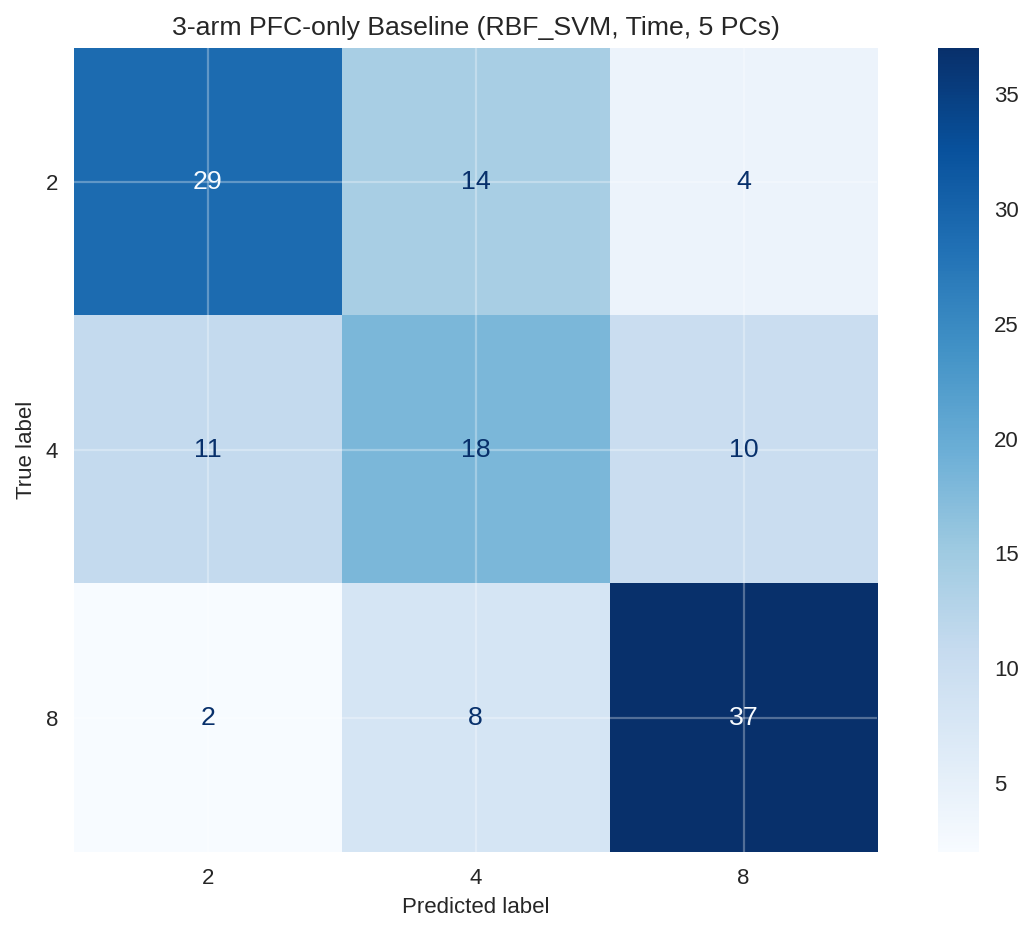

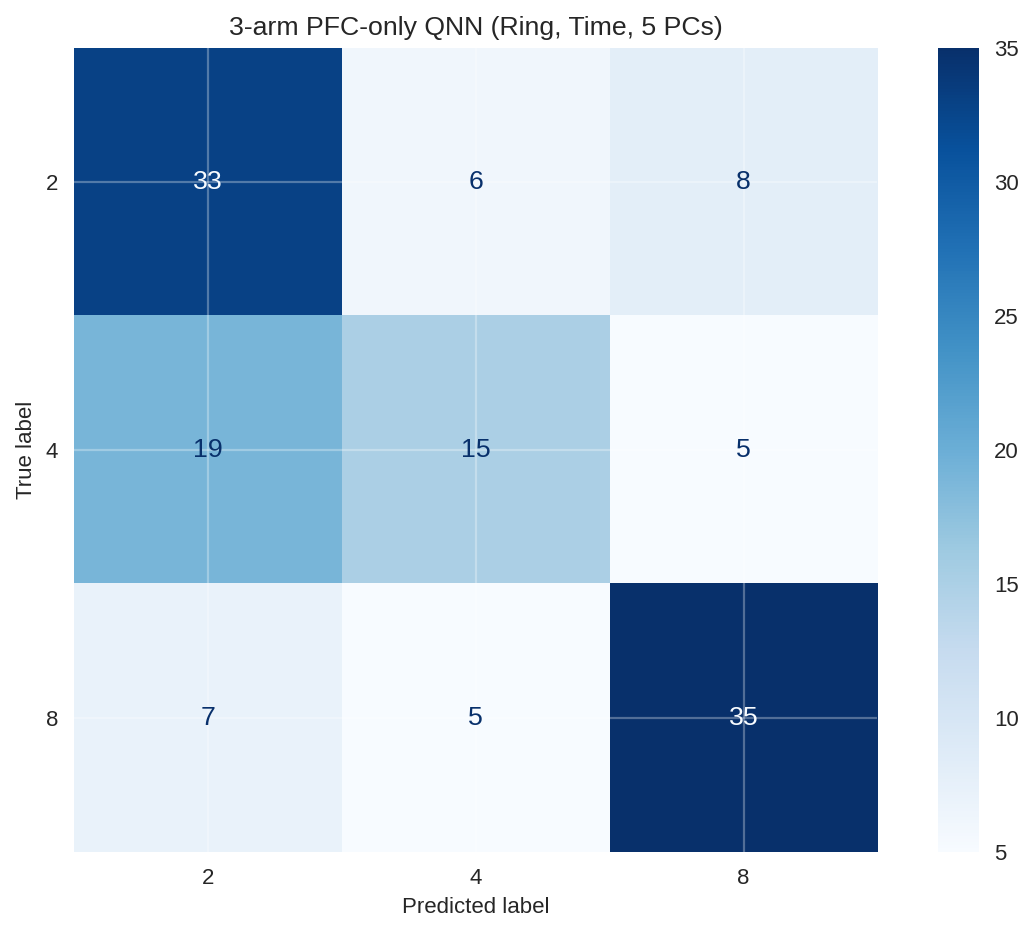

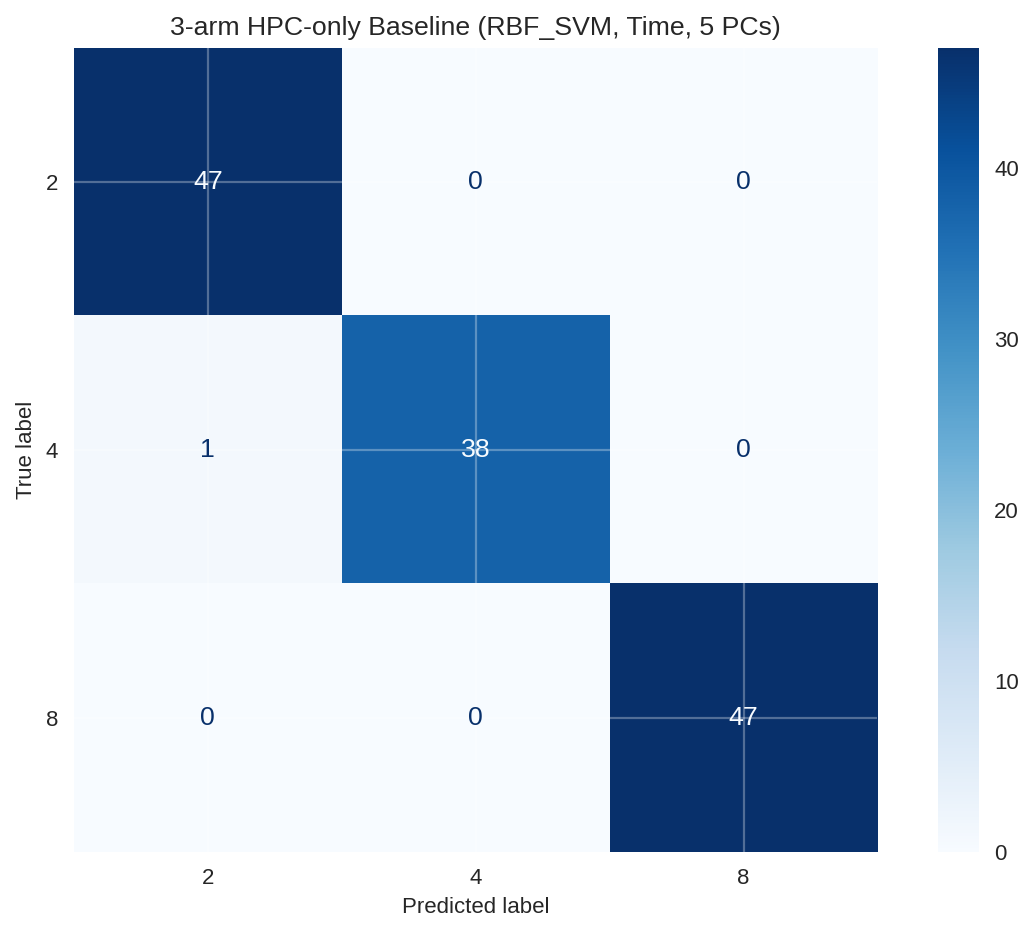

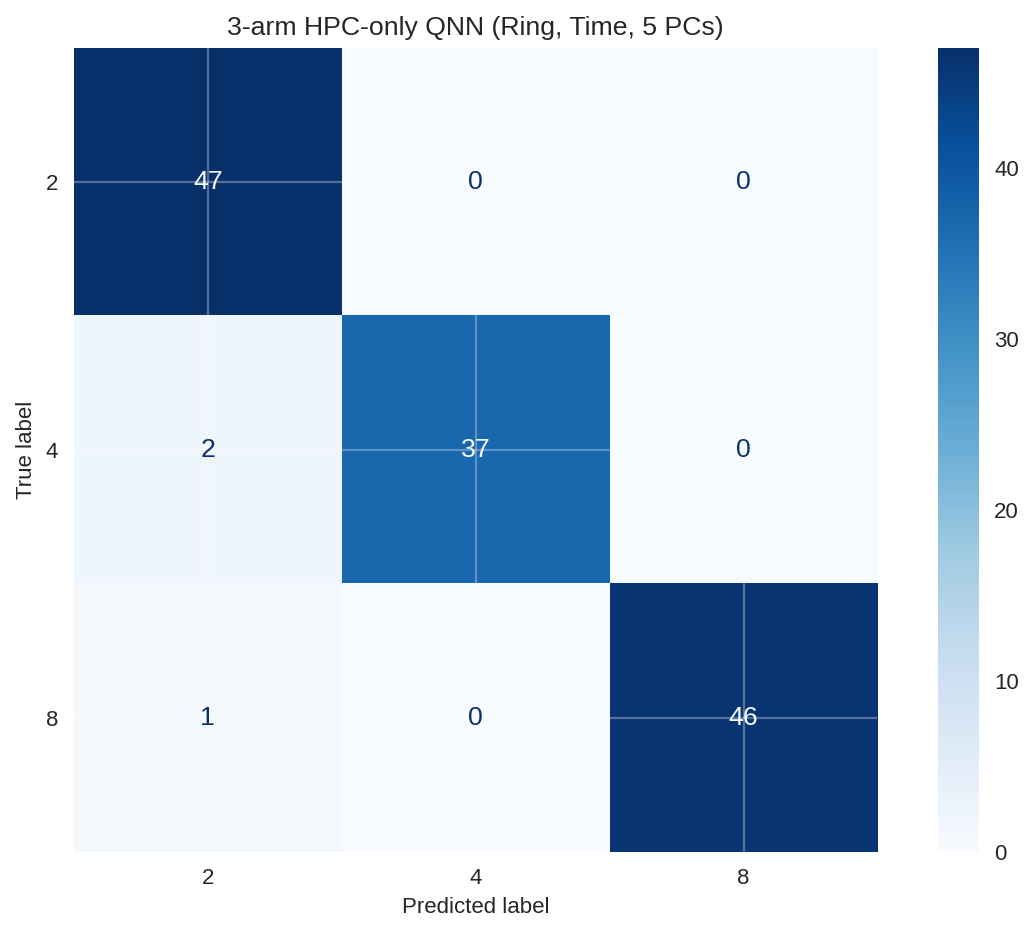

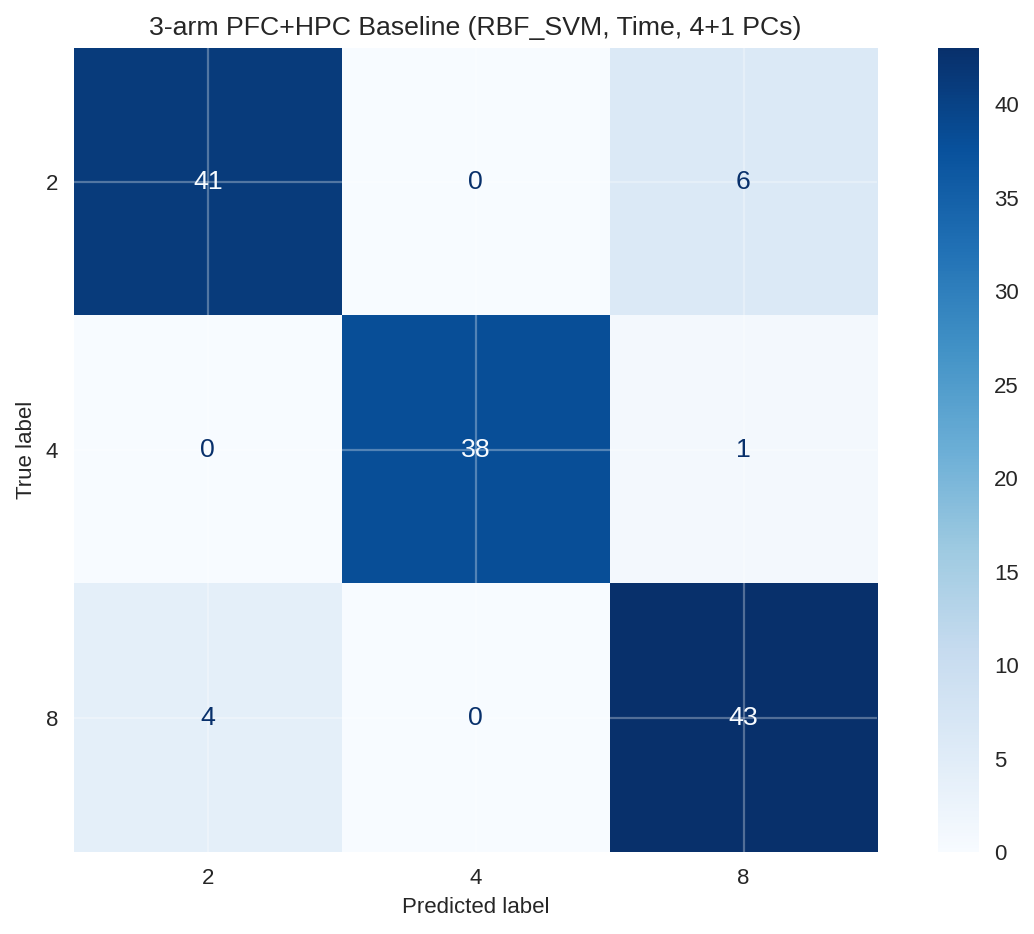

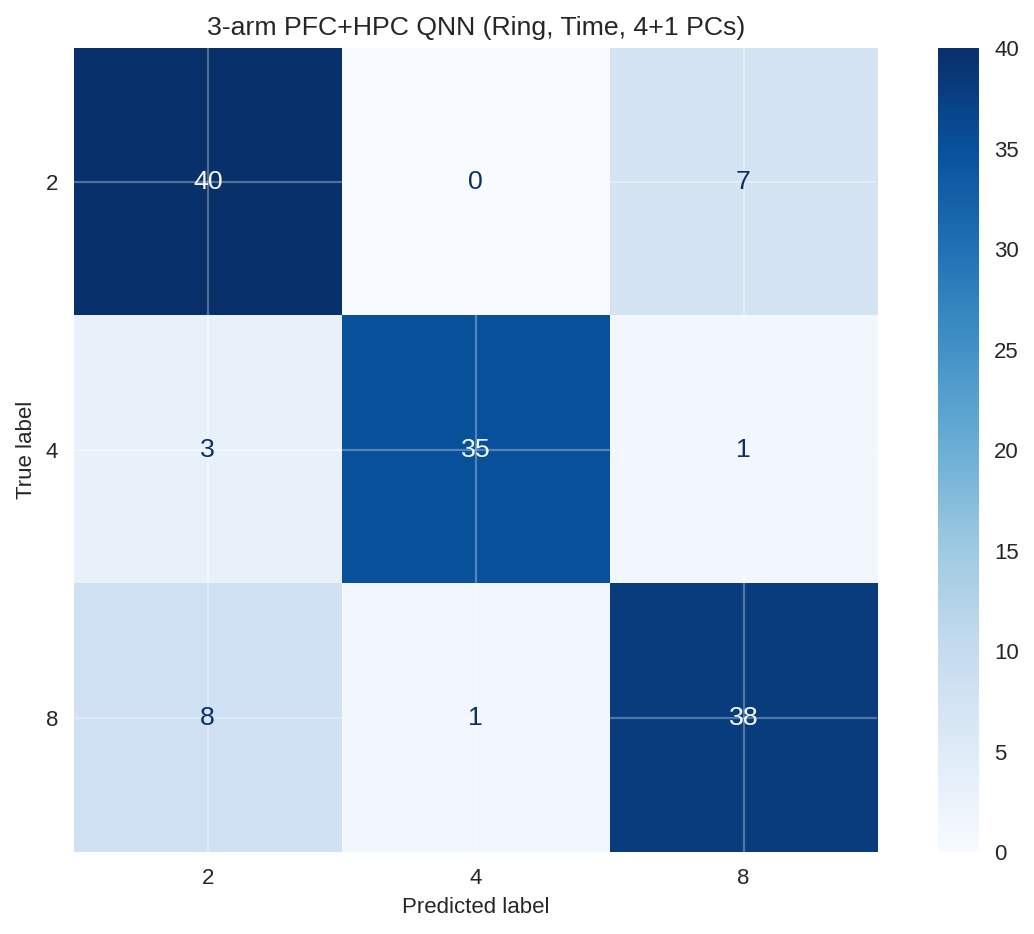

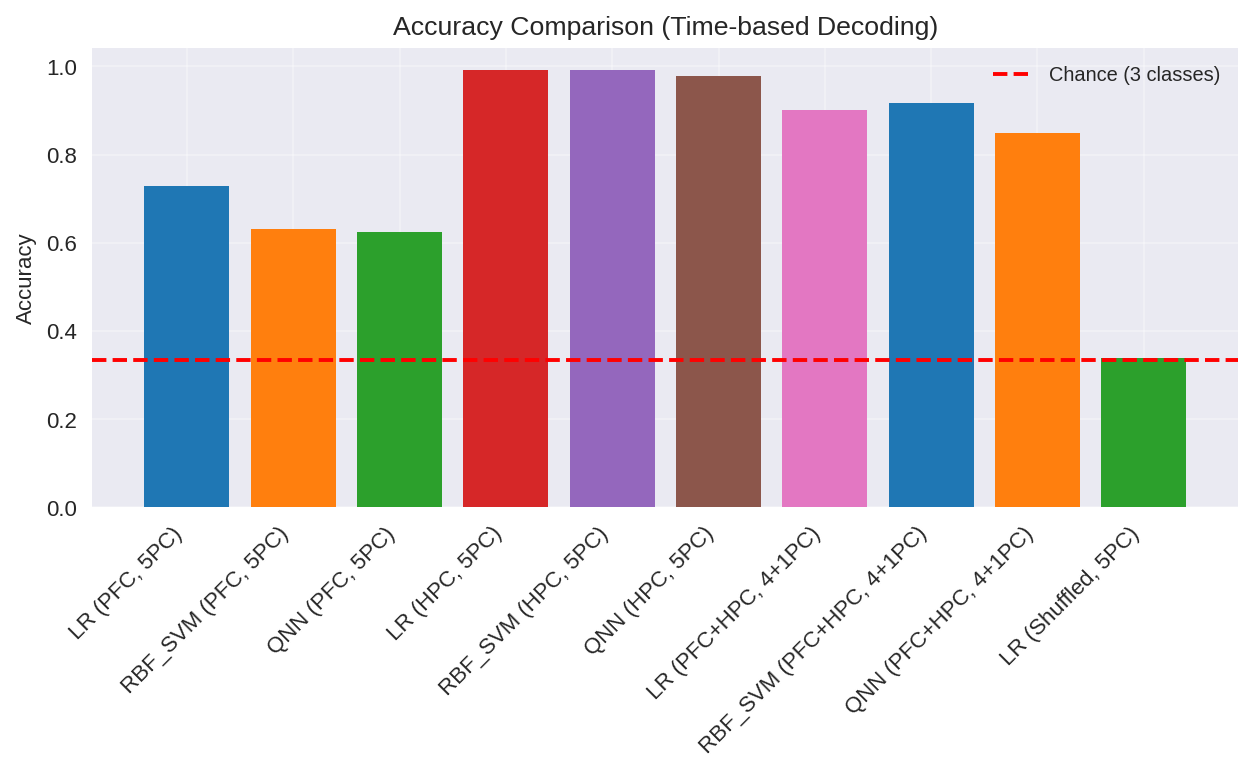

In [ ]:
# ---------- Main: Load and Run ----------

# Load data from pickle file
file_path = "qnn_data.pkl"
with open(file_path, "rb") as f:
    data = pickle.load(f)

tensor_pfc_rewarded = data["tensor_pfc_rewarded"]
tensor_hpc_rewarded = data["tensor_hpc_rewarded"]
event_arm_ids_rewarded = np.array(data["event_arm_ids_rewarded"])
trial_ids_rewarded = np.array(data["trial_ids_rewarded"])

# Transpose tensors to (neurons, time bins, events)
tensor_pfc_rewarded = np.transpose(tensor_pfc_rewarded, (1, 0, 2))
tensor_hpc_rewarded = np.transpose(tensor_hpc_rewarded, (1, 0, 2))
print(f"PFC tensor shape: {tensor_pfc_rewarded.shape}")
print(f"HPC tensor shape: {tensor_hpc_rewarded.shape}")

# Prepare data
X_pfc_time = tensor_to_event_list(tensor_pfc_rewarded)
X_hpc = tensor_to_event_list(tensor_hpc_rewarded)
y_3_raw = event_arm_ids_rewarded
groups_3 = trial_ids_rewarded
classes_3 = sorted(np.unique(y_3_raw))
y_3 = map_classes_to_012(y_3_raw, classes_3)
print(f"Class balance: {np.bincount(y_3)}")
print(f"Classes sorted: {classes_3}")
print(f"Group counts: {np.bincount(groups_3)}")

# Collect results for table
results = []

# Time-based experiments with PFC only (5 PCs)
print("\n=== Time-based PFC (tensor_pfc_rewarded, 5 PCs) ===")
res_time_pfc5, preds_time_pfc5 = eval_baselines(
    X_pfc_time, None, y_3, n_pcs_pfc=5, n_pcs_hpc=0, n_splits=3, 
    random_state=SEED, task_name="3arm-PFC-5PC-Time")

for name, metrics in res_time_pfc5.items():
    results.append({'Input': 'Time-based PFC',
        'Model': f'{name} (Classical)',
        'Architecture': 'N/A',
        'n_PCs_PFC': 5, 'n_PCs_HPC': 0,
        'ACC': metrics['acc'], 'ACC_sd': metrics['acc_sd'],
        'F1': metrics['f1'], 'F1_sd': metrics['f1_sd'],
        'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# Time-based experiments with HPC only (5 PCs)
print("\n=== Time-based HPC (tensor_hpc_rewarded, 5 PCs) ===")
res_time_hpc5, preds_time_hpc5 = eval_baselines(
    None, X_hpc, y_3, n_pcs_pfc=0, n_pcs_hpc=5, n_splits=3, 
    random_state=SEED, task_name="3arm-HPC-5PC-Time"
)
for name, metrics in res_time_hpc5.items():
    results.append({'Input': 'Time-based HPC',
        'Model': f'{name} (Classical)',
        'Architecture': 'N/A',
        'n_PCs_PFC': 0, 'n_PCs_HPC': 5,
        'ACC': metrics['acc'], 'ACC_sd': metrics['acc_sd'],
        'F1': metrics['f1'], 'F1_sd': metrics['f1_sd'],
        'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# Time-based experiments with PFC (4 PCs) + HPC (1 PC)
print("\n=== Time-based PFC + HPC (4+1 PCs) ===")
res_time_fus5, preds_time_fus5 = eval_baselines(
    X_pfc_time, X_hpc, y_3, n_pcs_pfc=4, n_pcs_hpc=1, n_splits=3, 
    random_state=SEED, task_name="3arm-Fusion-4+1-Time")

for name, metrics in res_time_fus5.items():
    results.append({'Input': 'Time-based PFC + HPC',
        'Model': f'{name} (Classical)',
        'Architecture': 'N/A',
        'n_PCs_PFC': 4, 'n_PCs_HPC': 1,
        'ACC': metrics['acc'], 'ACC_sd': metrics['acc_sd'],
        'F1': metrics['f1'], 'F1_sd': metrics['f1_sd'],
        'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# Time-based experiments with PFC only (30 PCs)
print("\n=== Time-based PFC (tensor_pfc_rewarded, 30 PCs) ===")
res_time_pfc30, preds_time_pfc30 = eval_baselines(
    X_pfc_time, None, y_3, n_pcs_pfc=30, n_pcs_hpc=0, n_splits=3, 
    random_state=SEED, task_name="3arm-PFC-30PC-Time")

for name, metrics in res_time_pfc30.items():
    results.append({'Input': 'Time-based PFC',
        'Model': f'{name} (Classical)',
        'Architecture': 'N/A',
        'n_PCs_PFC': 30, 'n_PCs_HPC': 0,
        'ACC': metrics['acc'], 'ACC_sd': metrics['acc_sd'],
        'F1': metrics['f1'], 'F1_sd': metrics['f1_sd'],
        'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# QNN experiments with PFC only (5 PCs)
print("\n=== QNN Time-based PFC (5 PCs) ===")
q3_time_pfc, (yT_time_pfc, yP_time_pfc) = run_qnn(
    X_pfc_time, None, y_3, n_pcs_pfc=5, n_pcs_hpc=0, groups=groups_3, 
    topology="ring", n_splits=3, task_name="3arm-PFC-Time")

results.append({'Input': 'Time-based PFC',
    'Model': 'QNN',
    'Architecture': 'Ring topology, 3 layers, 5 qubits',
    'n_PCs_PFC': 5, 'n_PCs_HPC': 0,
    'ACC': q3_time_pfc['acc'], 'ACC_sd': q3_time_pfc['acc_sd'],
    'F1': q3_time_pfc['f1'], 'F1_sd': q3_time_pfc['f1_sd'],
    'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# QNN experiments with HPC only (5 PCs)
print("\n=== QNN Time-based HPC (5 PCs) ===")
q3_time_hpc, (yT_time_hpc, yP_time_hpc) = run_qnn(
    None, X_hpc, y_3, n_pcs_pfc=0, n_pcs_hpc=5, groups=groups_3, 
    topology="ring", n_splits=3, task_name="3arm-HPC-Time")

results.append({
    'Input': 'Time-based HPC',
    'Model': 'QNN',
    'Architecture': 'Ring topology, 3 layers, 5 qubits',
    'n_PCs_PFC': 0, 'n_PCs_HPC': 5,
    'ACC': q3_time_hpc['acc'], 'ACC_sd': q3_time_hpc['acc_sd'],
    'F1': q3_time_hpc['f1'], 'F1_sd': q3_time_hpc['f1_sd'],
    'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# QNN experiments with PFC (4 PCs) + HPC (1 PC)
print("\n=== QNN Time-based PFC + HPC (4+1 PCs) ===")
q3_time_fus, (yT_time_fus, yP_time_fus) = run_qnn(
    X_pfc_time, X_hpc, y_3, n_pcs_pfc=4, n_pcs_hpc=1, groups=groups_3, 
    topology="ring", n_splits=3, task_name="3arm-Fusion-Time")

results.append({'Input': 'Time-based PFC + HPC',
    'Model': 'QNN',
    'Architecture': 'Ring topology, 3 layers, 5 qubits',
    'n_PCs_PFC': 4, 'n_PCs_HPC': 1,
    'ACC': q3_time_fus['acc'], 'ACC_sd': q3_time_fus['acc_sd'],
    'F1': q3_time_fus['f1'], 'F1_sd': q3_time_fus['f1_sd'],
    'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# Sanity check: Baselines with shuffled labels (PFC, 5 PCs, time-based)
print("\n=== Sanity Check: Shuffled Labels (PFC, 5 PCs, Time) ===")
res_shuffle_pfc5, preds_shuffle_pfc5 = eval_baselines(
    X_pfc_time, None, y_3, n_pcs_pfc=5, n_pcs_hpc=0, n_splits=3, 
    random_state=SEED, task_name="3arm-PFC-5PC-Shuffled", shuffle_labels=True)

for name, metrics in res_shuffle_pfc5.items():
    results.append({'Input': 'Time-based PFC (Shuffled)',
        'Model': f'{name} (Classical)',
        'Architecture': 'N/A',
        'n_PCs_PFC': 5, 'n_PCs_HPC': 0,
        'ACC': metrics['acc'], 'ACC_sd': metrics['acc_sd'],
        'F1': metrics['f1'], 'F1_sd': metrics['f1_sd'],
        'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# Permutation tests for classical models
for model in ['LR', 'LinSVM', 'RBF_SVM', 'RF']:
    p_time_pfc, acc_perm_pfc = permutation_test_baseline(
        X_pfc_time, None, y_3, n_pcs_pfc=5, n_pcs_hpc=0, clf_name=model, n_splits=3)
    
    for row in results:
        if row['Input'] == 'Time-based PFC' and row['Model'] == f'{model} (Classical)' and row['n_PCs_PFC'] == 5:
            row['Perm_p'] = p_time_pfc
            row['CI_ACC_low'] = acc_perm_pfc
            row['CI_ACC_high'] = acc_perm_pfc
    
    p_time_hpc, acc_perm_hpc = permutation_test_baseline(
        None, X_hpc, y_3, n_pcs_pfc=0, n_pcs_hpc=5, clf_name=model, n_splits=3)
    
    for row in results:
        if row['Input'] == 'Time-based HPC' and row['Model'] == f'{model} (Classical)' and row['n_PCs_HPC'] == 5:
            row['Perm_p'] = p_time_hpc
            row['CI_ACC_low'] = acc_perm_hpc
            row['CI_ACC_high'] = acc_perm_hpc
    
    p_time_fus, acc_perm_fus = permutation_test_baseline(
        X_pfc_time, X_hpc, y_3, n_pcs_pfc=4, n_pcs_hpc=1, clf_name=model, n_splits=3
    )
    for row in results:
        if row['Input'] == 'Time-based PFC + HPC' and row['Model'] == f'{model} (Classical)' and row['n_PCs_PFC'] == 4:
            row['Perm_p'] = p_time_fus
            row['CI_ACC_low'] = acc_perm_fus
            row['CI_ACC_high'] = acc_perm_fus

# Bootstrap CIs for QNN
ci_acc_low_pfc, ci_acc_high_pfc = bootstrap_ci_metric(yT_time_pfc, yP_time_pfc, accuracy_score)
for row in results:
    if row['Input'] == 'Time-based PFC' and row['Model'] == 'QNN':
        row['CI_ACC_low'] = ci_acc_low_pfc
        row['CI_ACC_high'] = ci_acc_high_pfc

ci_acc_low_hpc, ci_acc_high_hpc = bootstrap_ci_metric(yT_time_hpc, yP_time_hpc, accuracy_score)
for row in results:
    if row['Input'] == 'Time-based HPC' and row['Model'] == 'QNN':
        row['CI_ACC_low'] = ci_acc_low_hpc
        row['CI_ACC_high'] = ci_acc_high_hpc

ci_acc_low_fus, ci_acc_high_fus = bootstrap_ci_metric(yT_time_fus, yP_time_fus, accuracy_score)
for row in results:
    if row['Input'] == 'Time-based PFC + HPC' and row['Model'] == 'QNN':
        row['CI_ACC_low'] = ci_acc_low_fus
        row['CI_ACC_high'] = ci_acc_high_fus

# Results table
df_results = pd.DataFrame(results)
print("\n=== Results Table ===")
print(df_results.to_string(index=False))

# Confusion matrices for key models
cm_time_pfc_baseline = preds_time_pfc5["RBF_SVM"]
plot_confmat(cm_time_pfc_baseline[0], cm_time_pfc_baseline[1], 
             title="3-arm PFC-only Baseline (RBF_SVM, Time, 5 PCs)", labels=classes_3)

cm_time_pfc_qnn = (yT_time_pfc, yP_time_pfc)
plot_confmat(cm_time_pfc_qnn[0], cm_time_pfc_qnn[1], 
             title="3-arm PFC-only QNN (Ring, Time, 5 PCs)", labels=classes_3)

cm_time_hpc_baseline = preds_time_hpc5["RBF_SVM"]
plot_confmat(cm_time_hpc_baseline[0], cm_time_hpc_baseline[1], 
             title="3-arm HPC-only Baseline (RBF_SVM, Time, 5 PCs)", labels=classes_3)

cm_time_hpc_qnn = (yT_time_hpc, yP_time_hpc)
plot_confmat(cm_time_hpc_qnn[0], cm_time_hpc_qnn[1], 
             title="3-arm HPC-only QNN (Ring, Time, 5 PCs)", labels=classes_3)

cm_fus_baseline = preds_time_fus5["RBF_SVM"]
plot_confmat(cm_fus_baseline[0], cm_fus_baseline[1], 
             title="3-arm PFC+HPC Baseline (RBF_SVM, Time, 4+1 PCs)", labels=classes_3)

cm_fus_qnn = (yT_time_fus, yP_time_fus)
plot_confmat(cm_fus_qnn[0], cm_fus_qnn[1], title="3-arm PFC+HPC QNN (Ring, Time, 4+1 PCs)", labels=classes_3)

# Accuracy comparison plot
acc_dict = {'LR (PFC, 5PC)': res_time_pfc5['LR']['acc'],
    'RBF_SVM (PFC, 5PC)': res_time_pfc5['RBF_SVM']['acc'],
    'QNN (PFC, 5PC)': q3_time_pfc['acc'],
    'LR (HPC, 5PC)': res_time_hpc5['LR']['acc'],
    'RBF_SVM (HPC, 5PC)': res_time_hpc5['RBF_SVM']['acc'],
    'QNN (HPC, 5PC)': q3_time_hpc['acc'],
    'LR (PFC+HPC, 4+1PC)': res_time_fus5['LR']['acc'],
    'RBF_SVM (PFC+HPC, 4+1PC)': res_time_fus5['RBF_SVM']['acc'],
    'QNN (PFC+HPC, 4+1PC)': q3_time_fus['acc'],
    'LR (Shuffled, 5PC)': res_shuffle_pfc5['LR']['acc']}

plot_accuracy_comparison(acc_dict, title="Accuracy Comparison (Time-based Decoding)")

In [ ]:
# 8-ARMS: ONLY THE UPDATED BITS + MAIN
# Functions redefined for the 8-arms ALL dataset (suffixed *_all) 

# ---------- FIXED baseline CV for 8-arms (robust to rare classes) ----------
def eval_baselines_all(
    X_pfc: Optional[List[np.ndarray]],
    X_hpc: Optional[List[np.ndarray]],
    y: np.ndarray, n_pcs_pfc: int,
    n_pcs_hpc: int, n_splits: int = 3,
    random_state: int = 42, task_name: str = "",
    groups: Optional[np.ndarray] = None,) -> Tuple[Dict, Dict]:
    """
    Cross-validate classical models on the ALL (8-arms) dataset.

    - For stratified CV, shrink n_splits to <= min(class counts) to avoid folds failing.
    - If `groups` is provided, use GroupKFold with the requested n_splits (clipped to #groups).
    - Create a fresh splitter for each classifier (no iterator exhaustion).
    - Keep tiny Gaussian jitter to avoid degenerate decision boundaries.
    """
    y = np.asarray(y)
    n_samples = len(y)

    classifiers = [
        ("LR", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=random_state)),
        ("LinSVM", SVC(kernel="linear", C=1.0, tol=1e-3, class_weight="balanced",
                       decision_function_shape="ovr", random_state=random_state)),
        ("RBF_SVM", SVC(kernel="rbf", C=1.0, gamma="auto", tol=1e-3, class_weight="balanced",
                        decision_function_shape="ovr", random_state=random_state)),
        ("RF", RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1,
                                      class_weight="balanced", random_state=random_state)),]

    res, preds_all = {}, {}

    # Compute a safe number of splits for stratified CV
    if groups is None:
        # each class must have at least `n_splits` members
        binc = np.bincount(y)
        min_per_class = int(binc.min()) if len(binc) > 0 else 0
        n_splits_safe = max(2, min(n_splits, min_per_class))  # at least 2
    else:
        # GroupKFold: cannot exceed #unique groups
        n_splits_safe = max(2, min(n_splits, len(np.unique(groups))))

    for name, clf in classifiers:
        # Fresh splitter for EACH classifier
        if groups is None:
            splitter = StratifiedKFold(n_splits=n_splits_safe, shuffle=True, random_state=random_state)
            split_iter = splitter.split(np.arange(n_samples), y)
        else:
            splitter = GroupKFold(n_splits=n_splits_safe)
            split_iter = splitter.split(np.arange(n_samples), groups=groups)

        accs, f1s = [], []
        y_true_agg, y_pred_agg = [], []

        for tr, te in split_iter:
            # Basic sanity for very small folds
            if len(te) < 5 or len(tr) < 15:
                continue

            apca = AreaPCA(n_pcs_pfc, n_pcs_hpc).fit(
                [X_pfc[i] for i in tr] if X_pfc is not None else None,
                [X_hpc[i] for i in tr] if X_hpc is not None else None
            )
            Xtr = apca.transform(
                [X_pfc[i] for i in tr] if X_pfc is not None else None,
                [X_hpc[i] for i in tr] if X_hpc is not None else None
            )
            Xte = apca.transform(
                [X_pfc[i] for i in te] if X_pfc is not None else None,
                [X_hpc[i] for i in te] if X_hpc is not None else None
            )

            # Tiny jitter (numerical stability) – harmless and bug-safe
            Xtr = Xtr + np.random.normal(0, 1e-5, Xtr.shape)
            Xte = Xte + np.random.normal(0, 1e-5, Xte.shape)

            try:
                clf.fit(Xtr, y[tr])
                yhat = clf.predict(Xte)
            except Exception:
                # If a classifier still fails on a fold, skip it rather than crashing the run.
                continue

            accs.append(accuracy_score(y[te], yhat))
            f1s.append(f1_score(y[te], yhat, average="macro"))
            y_true_agg.extend(y[te]); y_pred_agg.extend(yhat)

        if not accs:
            res[name] = {"acc": 0.0, "acc_sd": 0.0, "f1": 0.0, "f1_sd": 0.0}
            preds_all[name] = (np.array([]), np.array([]))
        else:
            res[name] = {
                "acc": float(np.mean(accs)), "acc_sd": float(np.std(accs)),
                "f1": float(np.mean(f1s)), "f1_sd": float(np.std(f1s)),
            }
            preds_all[name] = (np.array(y_true_agg), np.array(y_pred_agg))

    return res, preds_all


def plot_confmat_all(y_true: np.ndarray, y_pred: np.ndarray, title: str, labels: List[int]) -> None:
    """
    Compact confusion matrix plot that supports any number of classes.
    - Assumes y_true and y_pred are already remapped to 0..K-1.
    - 'labels' should be the original class IDs (for axis tick labels).
    - Prints no intermediate text; only shows the figure.
    """
    if len(y_true) == 0 or len(y_pred) == 0:
        return
    k = len(labels)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(k)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(title)
    plt.gcf().set_size_inches(6, 4)  # smaller footprint
    plt.tight_layout()
    plt.show()


def plot_accuracy_comparison_all(acc_dict: Dict[str, float], title: str, n_classes: int) -> None:
    """
    Compact bar chart of model accuracies with a dashed chance line at 1/n_classes.
    - No extra prints; figure sized to be smaller than default.
    """
    models = list(acc_dict.keys())
    accs = list(acc_dict.values())
    plt.figure(figsize=(7, 4))
    plt.bar(models, accs)
    plt.axhline(y=1.0 / n_classes, linestyle='--', label=f'Chance (1/{n_classes})')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()


def run_qnn_all(X_pfc: Optional[List[np.ndarray]],
    X_hpc: Optional[List[np.ndarray]], y: np.ndarray,
    n_pcs_pfc: int, n_pcs_hpc: int,
    groups: np.ndarray, topology: str = "ring",
    n_splits: int = 3, task_name: str = "",
    n_layers: int = 6) -> Tuple[Dict, Tuple[np.ndarray, np.ndarray]]:
    """
    QNN CV loop for the ALL (8-arms) dataset.
    Differences vs your original:
    - Automatically infers n_classes from y and passes it to QNNClassifier.
    - Uses GroupKFold (same behavior you used for QNN).
    - Early stop via simple patience on training accuracy (no verbose prints).
    - Keeps conservative, bug-safe defaults.
    """
    y = np.asarray(y)
    groups = np.asarray(groups)
    n_groups = len(np.unique(groups))
    splitter = GroupKFold(n_splits=min(n_splits, n_groups))

    n_classes = int(len(np.unique(y)))  # e.g., 8 for 8-arms
    accs, f1s = [], []
    y_true_agg, y_pred_agg = [], []

    for tr, te in splitter.split(np.arange(len(y)), groups=groups):
        # Basic fold sanity
        if len(te) < 5 or len(tr) < 15:
            continue
        # Ensure the training fold actually contains all classes
        if len(np.unique(y[tr])) < n_classes:
            continue

        # PCA pipeline (uses your existing AreaPCA)
        apca = AreaPCA(n_pcs_pfc, n_pcs_hpc).fit(
            [X_pfc[i] for i in tr] if X_pfc is not None else None,
            [X_hpc[i] for i in tr] if X_hpc is not None else None
        )
        Xtr = apca.transform(
            [X_pfc[i] for i in tr] if X_pfc is not None else None,
            [X_hpc[i] for i in tr] if X_hpc is not None else None
        )
        Xte = apca.transform(
            [X_pfc[i] for i in te] if X_pfc is not None else None,
            [X_hpc[i] for i in te] if X_hpc is not None else None)

        # Tensors
        Xtr = torch.tensor(Xtr, dtype=torch.float32)
        Xte = torch.tensor(Xte, dtype=torch.float32)
        ytr = torch.tensor(y[tr], dtype=torch.long)
        yte = y[te]

        # Your existing QNNClassifier (must accept n_classes=...)
        model = QNNClassifier(n_qubits=n_pcs_pfc + n_pcs_hpc,
            n_layers=n_layers, topology=topology, n_classes=n_classes)
        
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50)
        criterion = nn.CrossEntropyLoss()

        # Simple patience on training accuracy (quiet)
        best_acc, patience, patience_left = -1.0, 40, 40
        best_state = None
        for epoch in range(800):
            model.train()
            optimizer.zero_grad()
            out = model(Xtr)
            # Defensive check: logits must have n_classes columns
            if out.shape[1] != n_classes:
                raise RuntimeError(f"QNN logits shape {out.shape} != n_classes={n_classes}. "
                    "Re-run the cell defining QNNClassifier so it accepts n_classes.")
            loss = criterion(out, ytr)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step(loss)

            with torch.no_grad():
                acc_tr = (out.argmax(dim=1) == ytr).float().mean().item()
                if acc_tr > best_acc + 1e-4:
                    best_acc = acc_tr
                    best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                    patience_left = patience
                else:
                    patience_left -= 1
                    if patience_left <= 0:
                        break

        if best_state is not None:
            model.load_state_dict(best_state)

        model.eval()
        with torch.no_grad():
            logits = model(Xte)
            yhat = logits.argmax(dim=1).cpu().numpy()

        accs.append(accuracy_score(yte, yhat))
        f1s.append(f1_score(yte, yhat, average="macro"))
        y_true_agg.extend(yte)
        y_pred_agg.extend(yhat)

    y_true_agg = np.array(y_true_agg)
    y_pred_agg = np.array(y_pred_agg)

    if not accs:
        return {"acc": 0.0, "acc_sd": 0.0, "f1": 0.0, "f1_sd": 0.0}, (np.array([]), np.array([]))

    res = {"acc": float(np.mean(accs)), "acc_sd": float(np.std(accs)),
        "f1": float(np.mean(f1s)), "f1_sd": float(np.std(f1s)),}
    return res, (y_true_agg, y_pred_agg)

               Input               Model                      Architecture  n_PCs_PFC  n_PCs_HPC      ACC   ACC_sd       F1    F1_sd Perm_p  CI_ACC_low  CI_ACC_high
      Time-based PFC      LR (Classical)                               N/A          8          0 0.494444 0.054997 0.295628 0.037472   None         NaN          NaN
      Time-based PFC  LinSVM (Classical)                               N/A          8          0 0.511111 0.074949 0.306101 0.049188   None         NaN          NaN
      Time-based PFC RBF_SVM (Classical)                               N/A          8          0 0.516667 0.062361 0.327006 0.059110   None         NaN          NaN
      Time-based PFC      RF (Classical)                               N/A          8          0 0.544444 0.020787 0.258573 0.012525   None         NaN          NaN
      Time-based HPC      LR (Classical)                               N/A          0          8 0.950000 0.036004 0.864373 0.111069   None         NaN          NaN
      Time

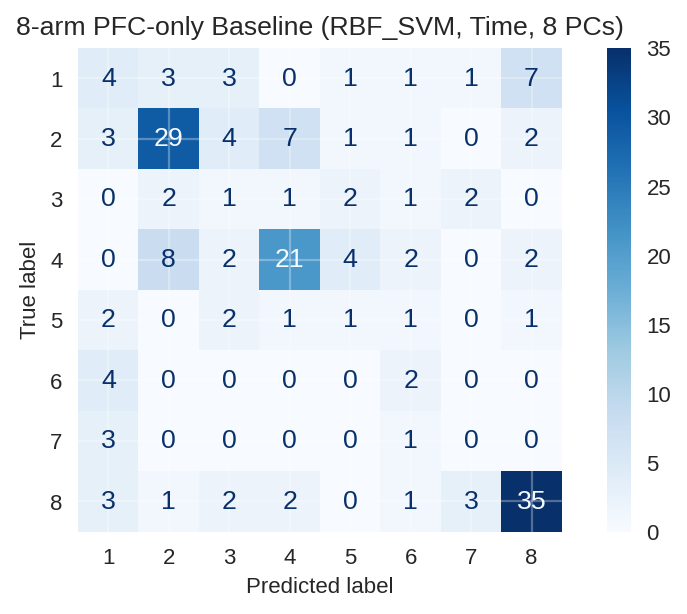

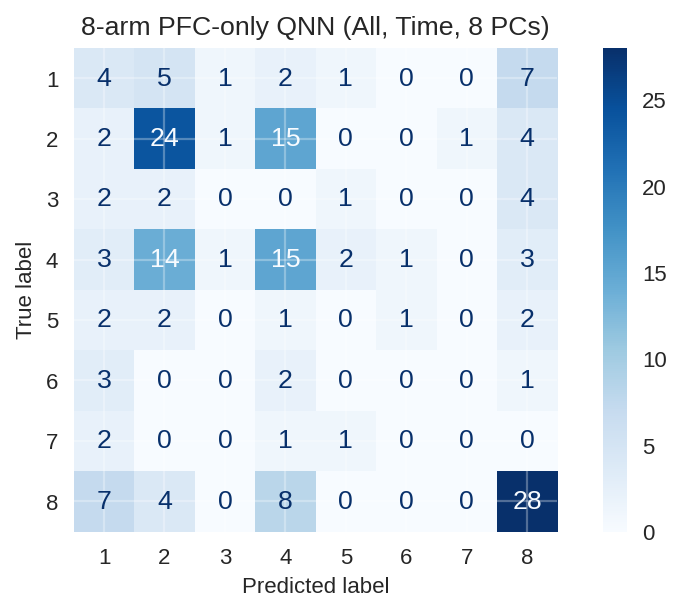

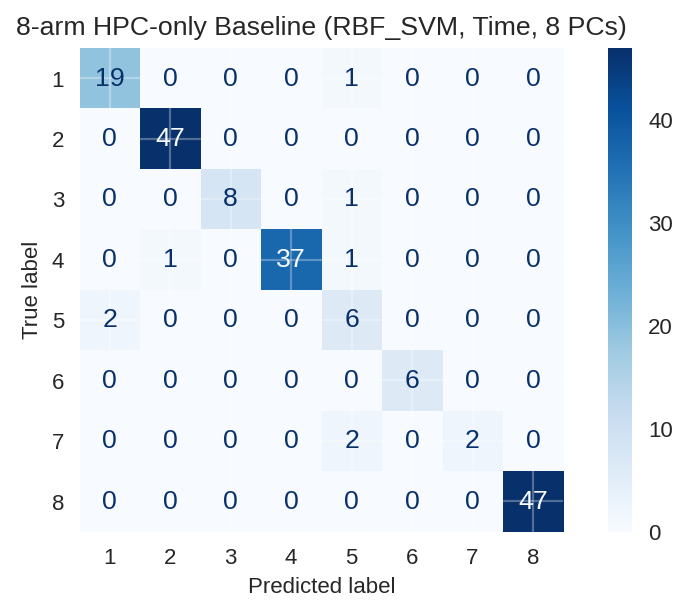

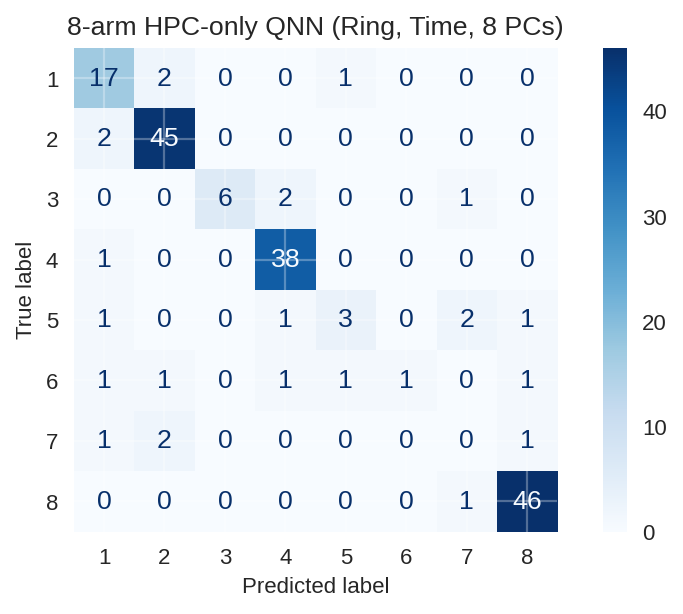

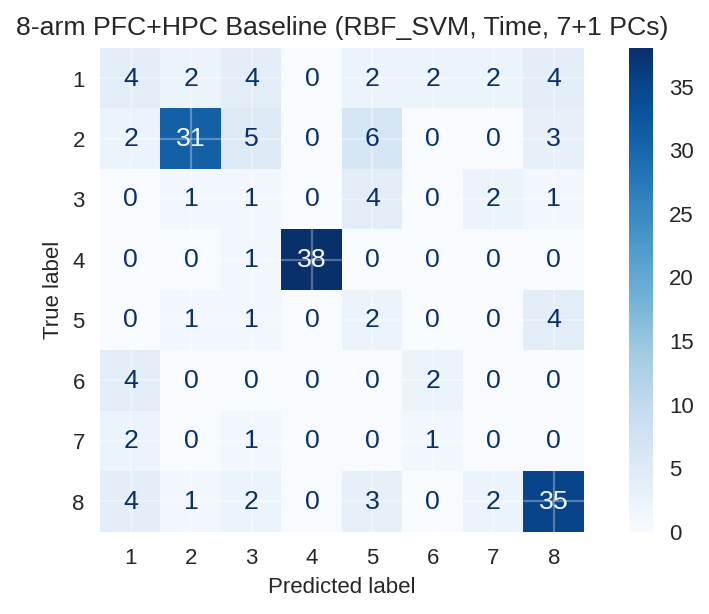

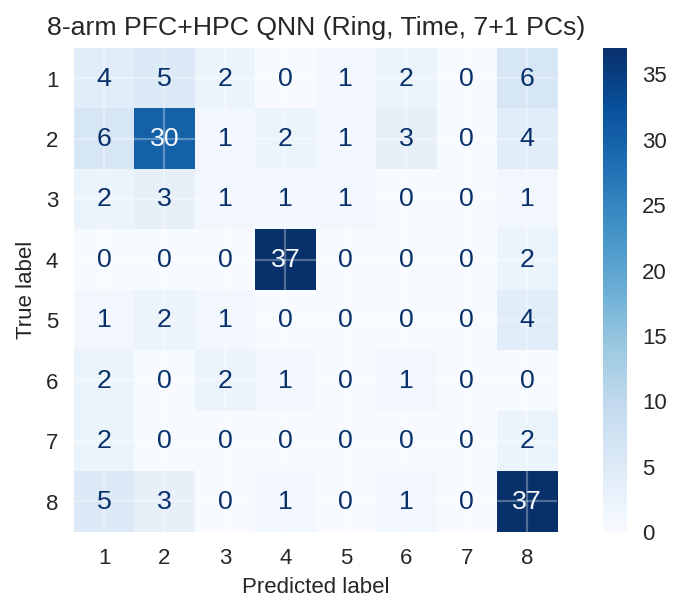

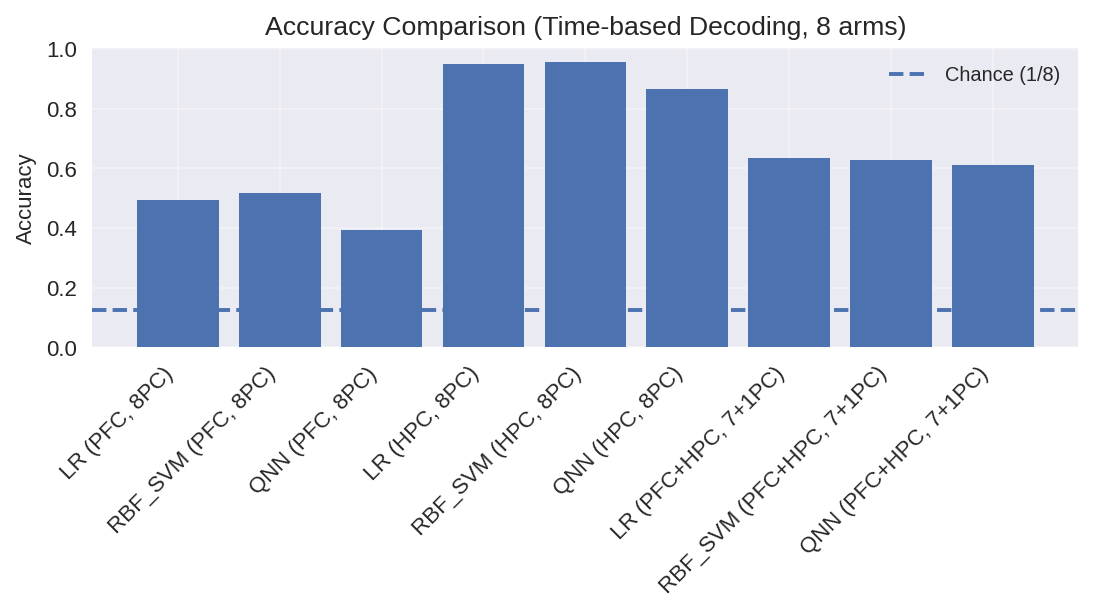

In [ ]:
# --------------------------------- MAIN (8 arms, *_all) ---------------------------------

# 1) Load ALL dataset from pickle file
file_path = "qnn_data.pkl"
with open(file_path, "rb") as f:
    data = pickle.load(f)

tensor_pfc_all    = data["tensor_pfc_all"]
tensor_hpc_all    = data["tensor_hpc_all"]
event_arm_ids_all = np.array(data["event_arm_ids_all"])
trial_ids_all     = np.array(data["trial_ids_all"])

# 2) Reorder to (neurons, time, events)
tensor_pfc_all = np.transpose(tensor_pfc_all, (1, 0, 2))
tensor_hpc_all = np.transpose(tensor_hpc_all, (1, 0, 2))

# 3) Convert tensors to per-event matrices and remap labels to 0..K-1 (K=8)
X_pfc_time = tensor_to_event_list(tensor_pfc_all)
X_hpc      = tensor_to_event_list(tensor_hpc_all)
y_raw      = event_arm_ids_all
groups     = trial_ids_all
classes_k  = sorted(np.unique(y_raw))           # original class IDs (8 arms)
y_k        = map_classes_to_012(y_raw, classes_k)
n_classes  = len(classes_k)

# 4) Run experiments (quiet) and collect a single final results table
results = []

# ---- Classical baselines: PFC only (8 PCs)
res_pfc8, preds_pfc8 = eval_baselines_all(X_pfc_time, None, y_k, n_pcs_pfc=8, n_pcs_hpc=0,
    n_splits=3, random_state=42, task_name="8arm-PFC-8PC-Time", groups=groups)

for name, metrics in res_pfc8.items():
    results.append({'Input': 'Time-based PFC', 'Model': f'{name} (Classical)', 'Architecture': 'N/A',
        'n_PCs_PFC': 8, 'n_PCs_HPC': 0,
        'ACC': metrics['acc'], 'ACC_sd': metrics['acc_sd'],
        'F1': metrics['f1'], 'F1_sd': metrics['f1_sd'],
        'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# ---- Classical baselines: HPC only (8 PCs)
res_hpc8, preds_hpc8 = eval_baselines_all(None, X_hpc, y_k, n_pcs_pfc=0, n_pcs_hpc=8,
    n_splits=3, random_state=42, task_name="8arm-HPC-8PC-Time", groups=groups)

for name, metrics in res_hpc8.items():
    results.append({'Input': 'Time-based HPC', 'Model': f'{name} (Classical)', 'Architecture': 'N/A',
        'n_PCs_PFC': 0, 'n_PCs_HPC': 8,
        'ACC': metrics['acc'], 'ACC_sd': metrics['acc_sd'],
        'F1': metrics['f1'], 'F1_sd': metrics['f1_sd'],
        'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# ---- Classical baselines: Fusion PFC+HPC (7+1 PCs = total 8)
res_fus8, preds_fus8 = eval_baselines_all(X_pfc_time, X_hpc, y_k, n_pcs_pfc=7, n_pcs_hpc=1,
    n_splits=3, random_state=42, task_name="8arm-Fusion-7+1-Time", groups=groups)

for name, metrics in res_fus8.items():
    results.append({'Input': 'Time-based PFC + HPC', 'Model': f'{name} (Classical)', 'Architecture': 'N/A',
        'n_PCs_PFC': 7, 'n_PCs_HPC': 1,
        'ACC': metrics['acc'], 'ACC_sd': metrics['acc_sd'],
        'F1': metrics['f1'], 'F1_sd': metrics['f1_sd'],
        'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# ---- QNN: PFC only (8 PCs = 8 qubits), topology "all"
q8_pfc, (yT_pfc, yP_pfc) = run_qnn_all(X_pfc_time, None, y_k, n_pcs_pfc=8, n_pcs_hpc=0, groups=groups,
    topology="all", n_splits=3, task_name="8arm-PFC-Time", n_layers=8)

results.append({'Input': 'Time-based PFC', 'Model': 'QNN', 'Architecture': 'All topology, 8 layers, 8 qubits',
    'n_PCs_PFC': 8, 'n_PCs_HPC': 0,
    'ACC': q8_pfc['acc'], 'ACC_sd': q8_pfc['acc_sd'],
    'F1': q8_pfc['f1'], 'F1_sd': q8_pfc['f1_sd'],
    'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# ---- QNN: HPC only (8 PCs = 8 qubits), topology "ring"
q8_hpc, (yT_hpc, yP_hpc) = run_qnn_all(None, X_hpc, y_k, n_pcs_pfc=0, n_pcs_hpc=8, groups=groups,
    topology="ring", n_splits=3, task_name="8arm-HPC-Time", n_layers=6)

results.append({'Input': 'Time-based HPC', 'Model': 'QNN', 'Architecture': 'Ring topology, 6 layers, 8 qubits',
    'n_PCs_PFC': 0, 'n_PCs_HPC': 8, 'ACC': q8_hpc['acc'], 'ACC_sd': q8_hpc['acc_sd'],
    'F1': q8_hpc['f1'], 'F1_sd': q8_hpc['f1_sd'],
    'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# ---- QNN: Fusion PFC+HPC (7+1 qubits = 8), topology "ring"
q8_fus, (yT_fus, yP_fus) = run_qnn_all(
    X_pfc_time, X_hpc, y_k, n_pcs_pfc=7, n_pcs_hpc=1, groups=groups,
    topology="ring", n_splits=3, task_name="8arm-Fusion-Time", n_layers=6
)
results.append({'Input': 'Time-based PFC + HPC', 'Model': 'QNN', 'Architecture': 'Ring topology, 6 layers, 8 qubits',
    'n_PCs_PFC': 7, 'n_PCs_HPC': 1,
    'ACC': q8_fus['acc'], 'ACC_sd': q8_fus['acc_sd'],'F1': q8_fus['f1'], 'F1_sd': q8_fus['f1_sd'],
    'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# ---- Bootstrap CIs for the QNN rows only (kept quiet)
ci_acc_low_pfc, ci_acc_high_pfc = bootstrap_ci_metric(yT_pfc, yP_pfc, accuracy_score)
ci_acc_low_hpc, ci_acc_high_hpc = bootstrap_ci_metric(yT_hpc, yP_hpc, accuracy_score)
ci_acc_low_fus, ci_acc_high_fus = bootstrap_ci_metric(yT_fus, yP_fus, accuracy_score)
for row in results:
    if row['Model'] == 'QNN' and row['Input'] == 'Time-based PFC':
        row['CI_ACC_low'] = ci_acc_low_pfc; row['CI_ACC_high'] = ci_acc_high_pfc
    if row['Model'] == 'QNN' and row['Input'] == 'Time-based HPC':
        row['CI_ACC_low'] = ci_acc_low_hpc; row['CI_ACC_high'] = ci_acc_high_hpc
    if row['Model'] == 'QNN' and row['Input'] == 'Time-based PFC + HPC':
        row['CI_ACC_low'] = ci_acc_low_fus; row['CI_ACC_high'] = ci_acc_high_fus

# 5) FINAL TABLE (only print once)
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# 6) COMPACT PLOTS (no extra prints)
cm_pfc_base = preds_pfc8["RBF_SVM"]
plot_confmat_all(cm_pfc_base[0], cm_pfc_base[1], title="8-arm PFC-only Baseline (RBF_SVM, Time, 8 PCs)", labels=classes_k)

plot_confmat_all(yT_pfc, yP_pfc, title="8-arm PFC-only QNN (All, Time, 8 PCs)", labels=classes_k)

cm_hpc_base = preds_hpc8["RBF_SVM"]
plot_confmat_all(cm_hpc_base[0], cm_hpc_base[1], title="8-arm HPC-only Baseline (RBF_SVM, Time, 8 PCs)", labels=classes_k)

plot_confmat_all(yT_hpc, yP_hpc, title="8-arm HPC-only QNN (Ring, Time, 8 PCs)", labels=classes_k)

cm_fus_base = preds_fus8["RBF_SVM"]
plot_confmat_all(cm_fus_base[0], cm_fus_base[1], title="8-arm PFC+HPC Baseline (RBF_SVM, Time, 7+1 PCs)", labels=classes_k)

plot_confmat_all(yT_fus, yP_fus, title="8-arm PFC+HPC QNN (Ring, Time, 7+1 PCs)", labels=classes_k)

acc_dict = {'LR (PFC, 8PC)': res_pfc8['LR']['acc'],
    'RBF_SVM (PFC, 8PC)': res_pfc8['RBF_SVM']['acc'],
    'QNN (PFC, 8PC)': q8_pfc['acc'],
    'LR (HPC, 8PC)': res_hpc8['LR']['acc'],
    'RBF_SVM (HPC, 8PC)': res_hpc8['RBF_SVM']['acc'],
    'QNN (HPC, 8PC)': q8_hpc['acc'],
    'LR (PFC+HPC, 7+1PC)': res_fus8['LR']['acc'],
    'RBF_SVM (PFC+HPC, 7+1PC)': res_fus8['RBF_SVM']['acc'],
    'QNN (PFC+HPC, 7+1PC)': q8_fus['acc'],}

plot_accuracy_comparison_all(acc_dict, title="Accuracy Comparison (Time-based Decoding, 8 arms)", n_classes=n_classes)

In [ ]:
# pre-event decoding decision

PFC tensor shape: (20, 399, 132)
HPC tensor shape: (20, 40, 132)
Class balance: [47 38 47]
Classes sorted: [np.int64(2), np.int64(4), np.int64(8)]
Group counts: [2 4 3 3 5 4 6 4 4 3 3 5 3 3 3 4 3 3 3 4 3 4 3 3 3 4 3 3 4 3 3 3 3 3 3 3 3
 3 3]

=== Time-based PFC (tensor_pfc_rewarded, 5 PCs) ===
=== Baselines (3arm-PFC-5PC-Time) PCs PFC/HPC = 5/0 ===
LR        ACC=0.386±0.019  F1=0.389±0.022
LinSVM    ACC=0.402±0.047  F1=0.401±0.047
RBF_SVM   ACC=0.379±0.057  F1=0.376±0.060
RF        ACC=0.326±0.043  F1=0.322±0.042

=== Time-based HPC (tensor_hpc_rewarded, 5 PCs) ===
=== Baselines (3arm-HPC-5PC-Time) PCs PFC/HPC = 0/5 ===
LR        ACC=0.712±0.060  F1=0.710±0.059
LinSVM    ACC=0.697±0.021  F1=0.696±0.025
RBF_SVM   ACC=0.705±0.049  F1=0.704±0.053
RF        ACC=0.606±0.070  F1=0.602±0.074

=== Time-based PFC + HPC (4+1 PCs) ===
=== Baselines (3arm-Fusion-4+1-Time) PCs PFC/HPC = 4/1 ===
LR        ACC=0.515±0.039  F1=0.515±0.039
LinSVM    ACC=0.530±0.011  F1=0.524±0.012
RBF_SVM   ACC=0.515±0

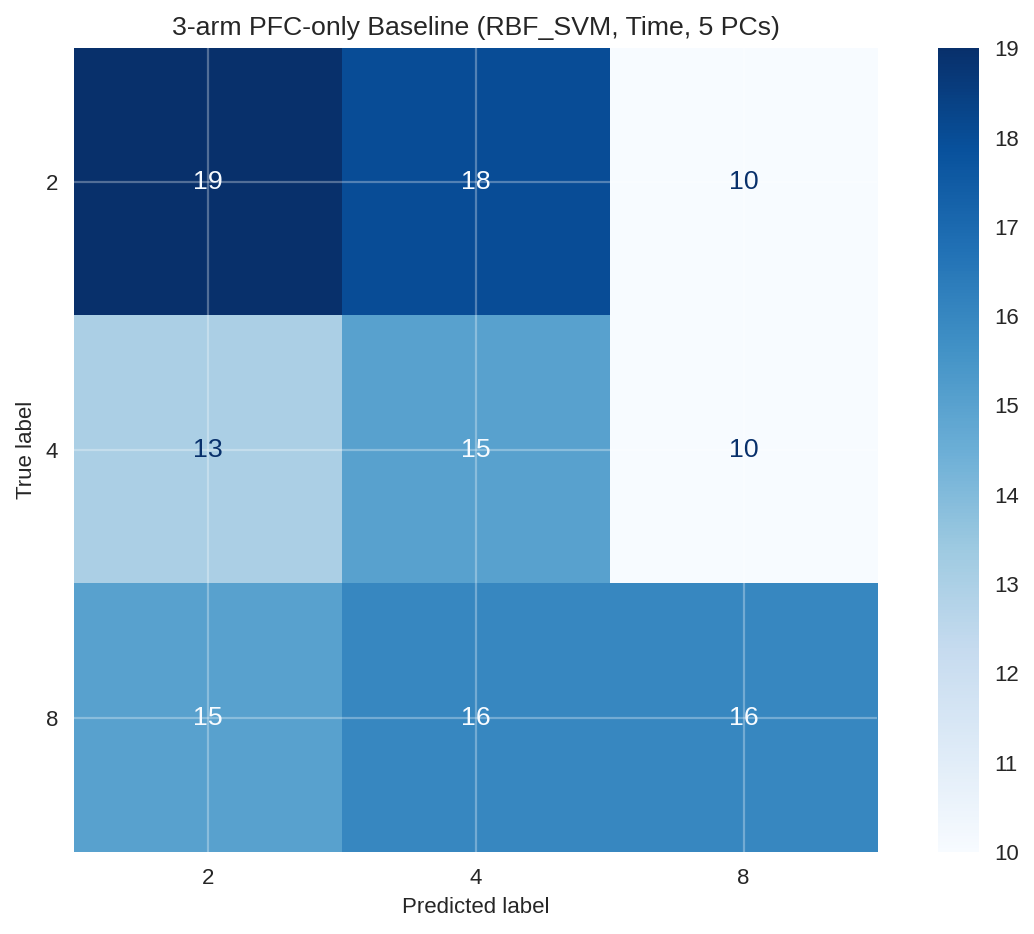

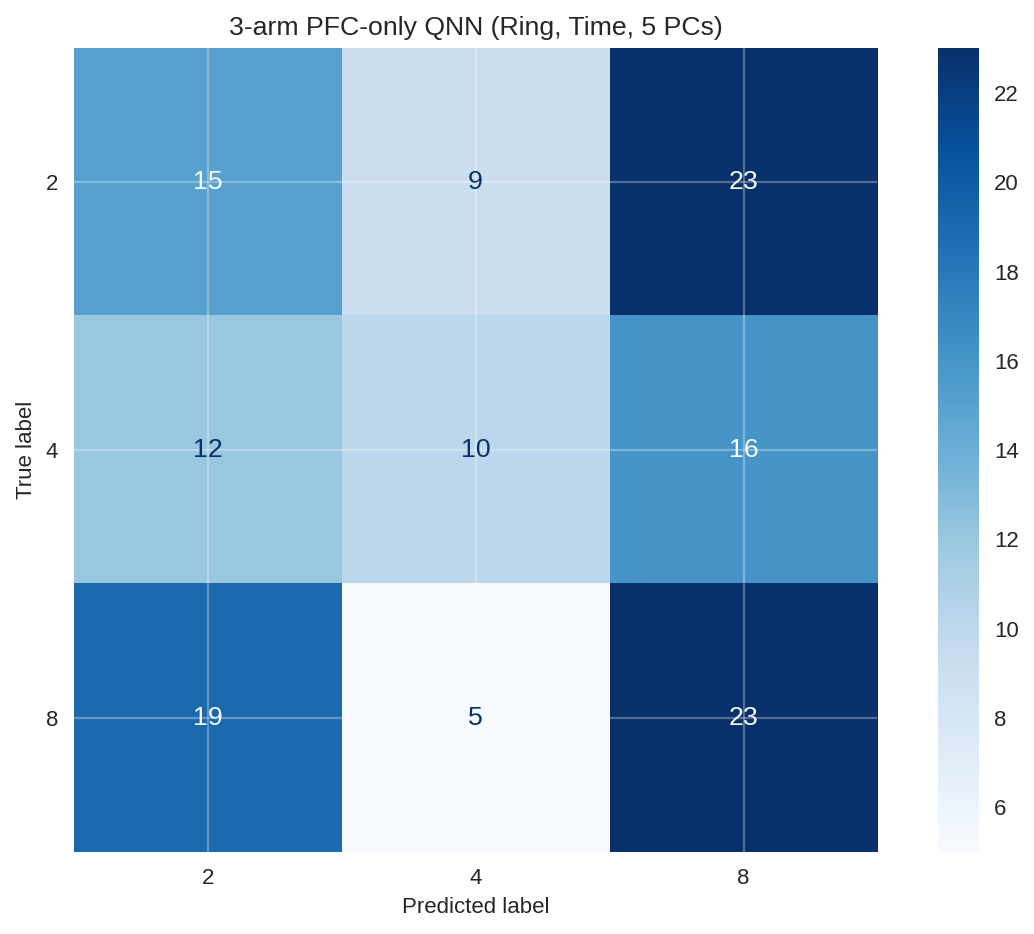

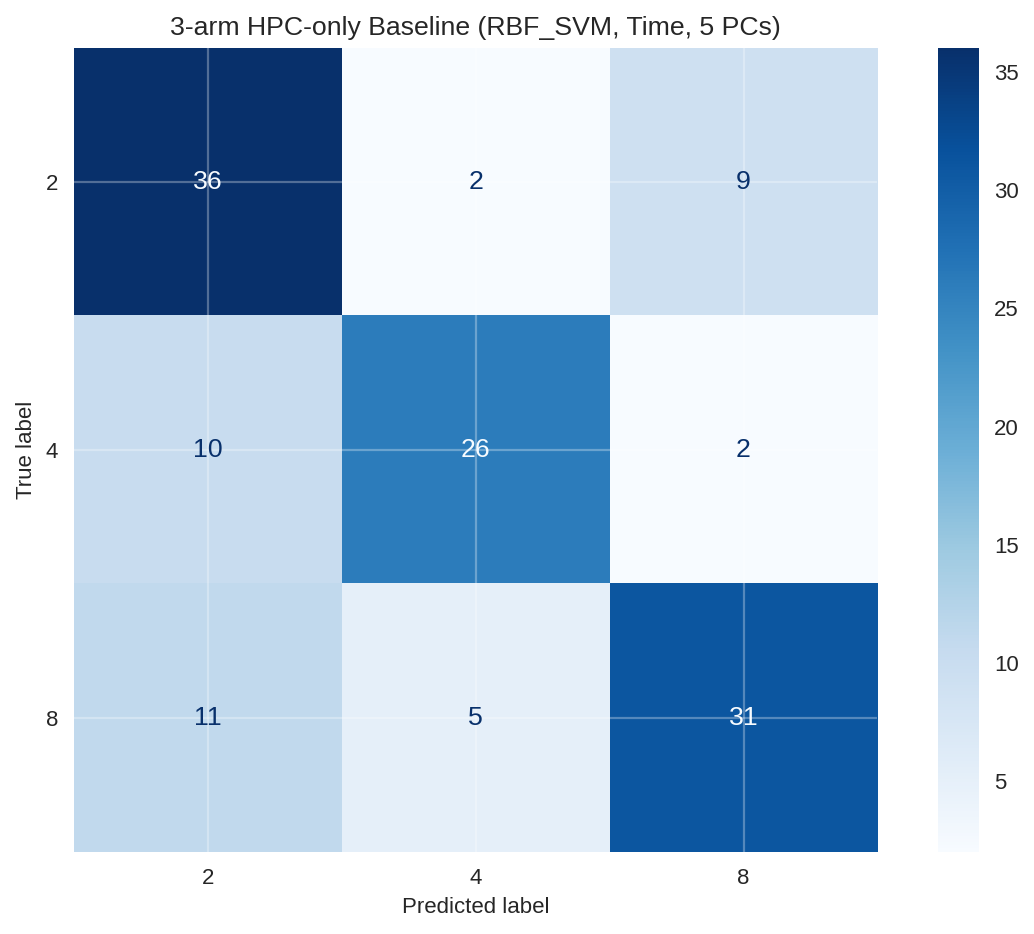

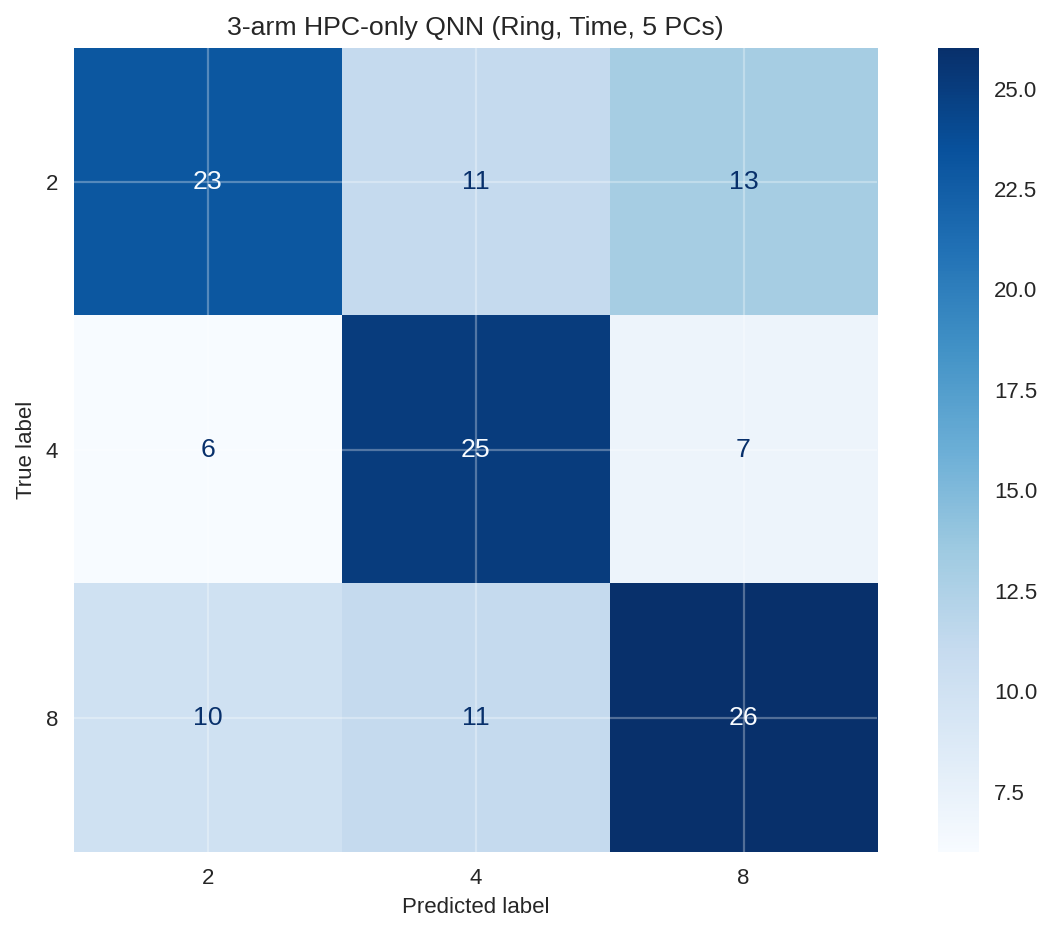

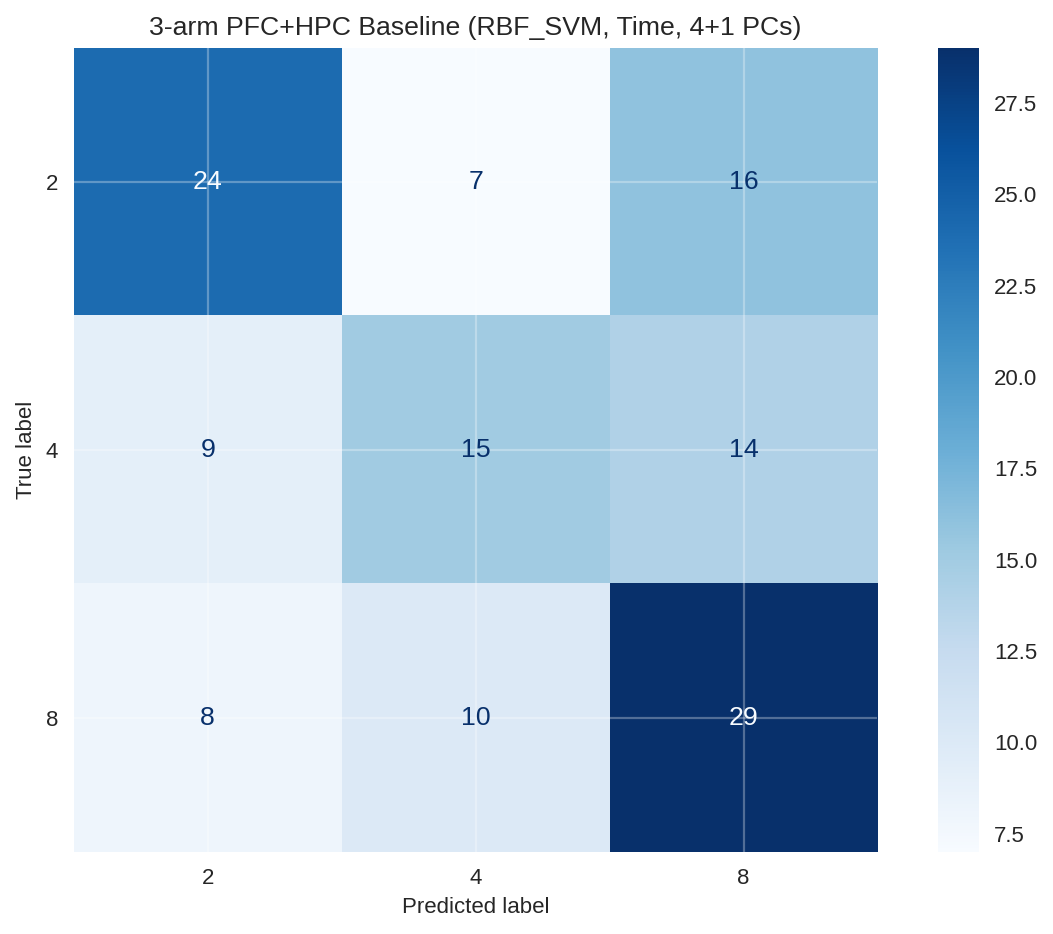

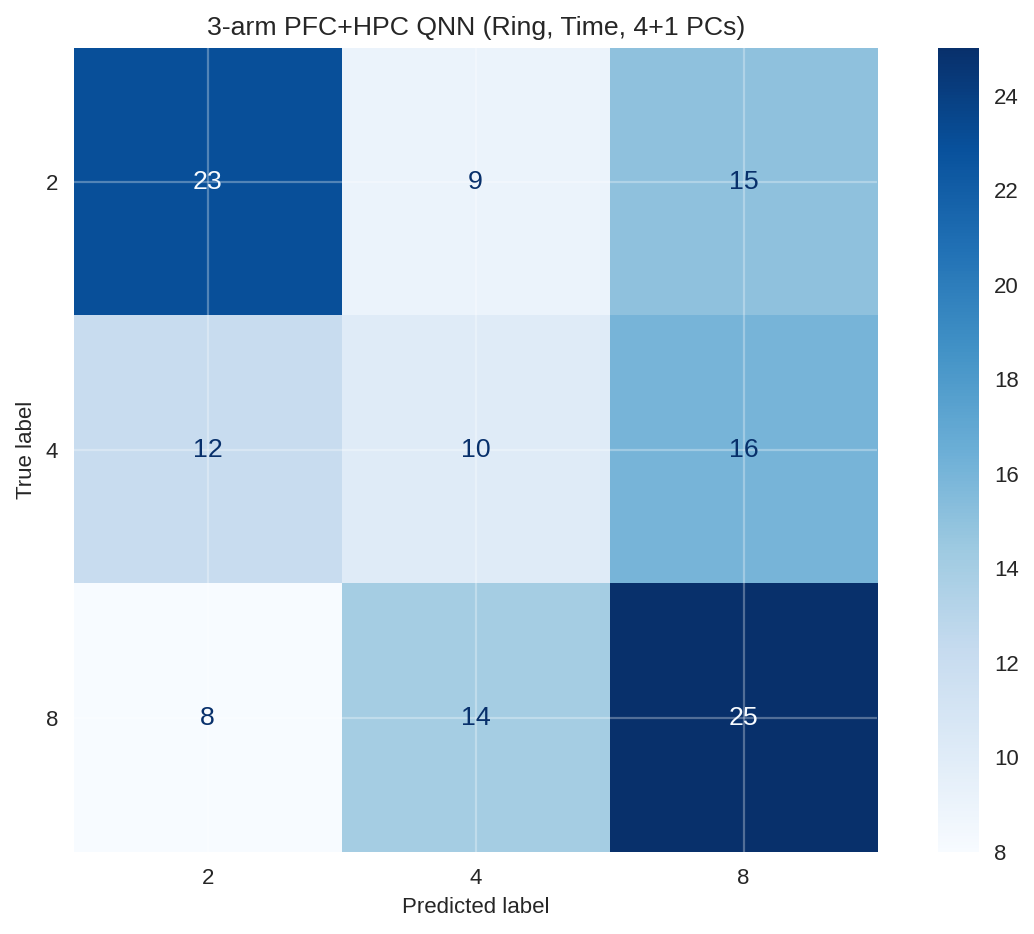

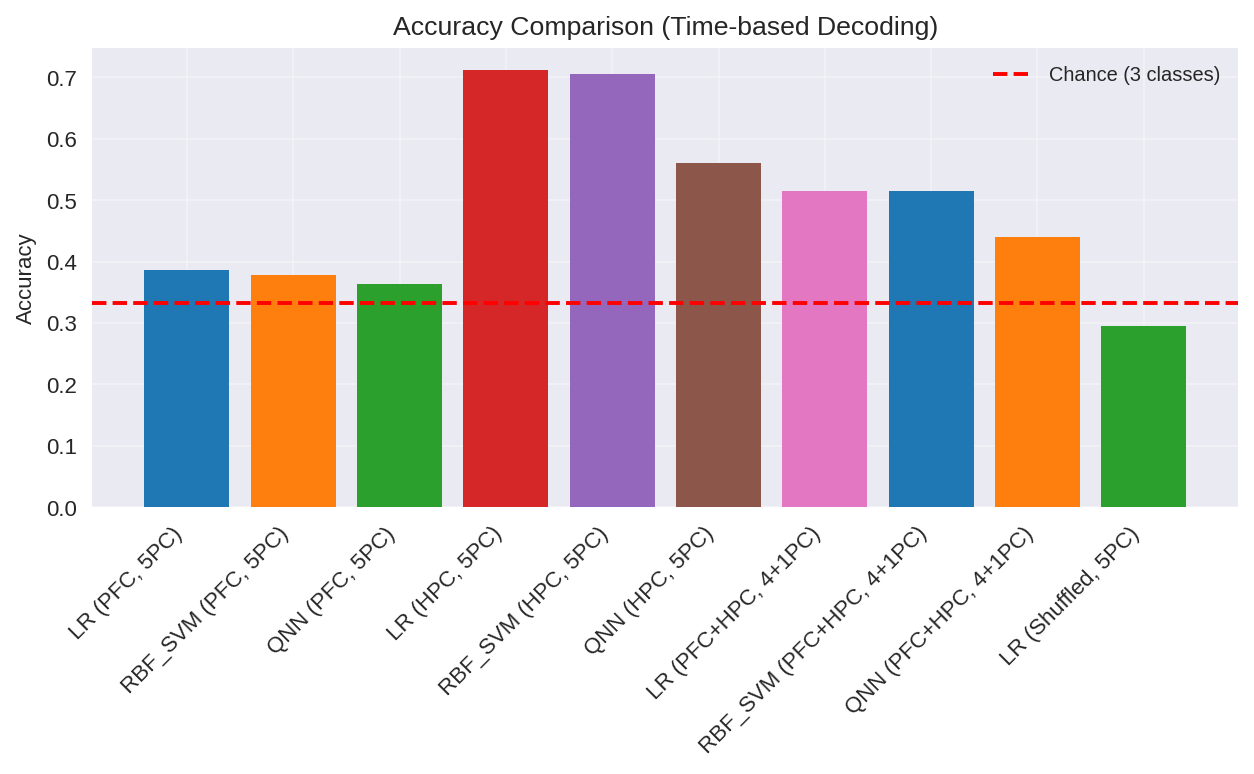

In [91]:
# ---------- Main: Load and Run ----------

# Load data from pickle file
file_path = "qnn_data_pre.pkl"
with open(file_path, "rb") as f:
    data = pickle.load(f)

tensor_pfc_rewarded = data["pre_tensor_pfc_rewarded"]
tensor_hpc_rewarded = data["pre_tensor_hpc_rewarded"]
event_arm_ids_rewarded = np.array(data["pre_event_arm_ids_rewarded"])
trial_ids_rewarded = np.array(data["pre_trial_ids_rewarded"])

# Transpose tensors to (neurons, time bins, events)
tensor_pfc_rewarded = np.transpose(tensor_pfc_rewarded, (1, 0, 2))
tensor_hpc_rewarded = np.transpose(tensor_hpc_rewarded, (1, 0, 2))
print(f"PFC tensor shape: {tensor_pfc_rewarded.shape}")
print(f"HPC tensor shape: {tensor_hpc_rewarded.shape}")

# Prepare data
X_pfc_time = tensor_to_event_list(tensor_pfc_rewarded)
X_hpc = tensor_to_event_list(tensor_hpc_rewarded)
y_3_raw = event_arm_ids_rewarded
groups_3 = trial_ids_rewarded
classes_3 = sorted(np.unique(y_3_raw))
y_3 = map_classes_to_012(y_3_raw, classes_3)
print(f"Class balance: {np.bincount(y_3)}")
print(f"Classes sorted: {classes_3}")
print(f"Group counts: {np.bincount(groups_3)}")

# Collect results for table
results = []

# Time-based experiments with PFC only (5 PCs)
print("\n=== Time-based PFC (tensor_pfc_rewarded, 5 PCs) ===")
res_time_pfc5, preds_time_pfc5 = eval_baselines(
    X_pfc_time, None, y_3, n_pcs_pfc=5, n_pcs_hpc=0, n_splits=3, 
    random_state=SEED, task_name="3arm-PFC-5PC-Time")

for name, metrics in res_time_pfc5.items():
    results.append({'Input': 'Time-based PFC',
        'Model': f'{name} (Classical)',
        'Architecture': 'N/A',
        'n_PCs_PFC': 5, 'n_PCs_HPC': 0,
        'ACC': metrics['acc'], 'ACC_sd': metrics['acc_sd'],
        'F1': metrics['f1'], 'F1_sd': metrics['f1_sd'],
        'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# Time-based experiments with HPC only (5 PCs)
print("\n=== Time-based HPC (tensor_hpc_rewarded, 5 PCs) ===")
res_time_hpc5, preds_time_hpc5 = eval_baselines(
    None, X_hpc, y_3, n_pcs_pfc=0, n_pcs_hpc=5, n_splits=3, 
    random_state=SEED, task_name="3arm-HPC-5PC-Time"
)
for name, metrics in res_time_hpc5.items():
    results.append({'Input': 'Time-based HPC',
        'Model': f'{name} (Classical)',
        'Architecture': 'N/A',
        'n_PCs_PFC': 0, 'n_PCs_HPC': 5,
        'ACC': metrics['acc'], 'ACC_sd': metrics['acc_sd'],
        'F1': metrics['f1'], 'F1_sd': metrics['f1_sd'],
        'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# Time-based experiments with PFC (4 PCs) + HPC (1 PC)
print("\n=== Time-based PFC + HPC (4+1 PCs) ===")
res_time_fus5, preds_time_fus5 = eval_baselines(
    X_pfc_time, X_hpc, y_3, n_pcs_pfc=4, n_pcs_hpc=1, n_splits=3, 
    random_state=SEED, task_name="3arm-Fusion-4+1-Time")

for name, metrics in res_time_fus5.items():
    results.append({'Input': 'Time-based PFC + HPC',
        'Model': f'{name} (Classical)',
        'Architecture': 'N/A',
        'n_PCs_PFC': 4, 'n_PCs_HPC': 1,
        'ACC': metrics['acc'], 'ACC_sd': metrics['acc_sd'],
        'F1': metrics['f1'], 'F1_sd': metrics['f1_sd'],
        'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# Time-based experiments with PFC only (30 PCs)
print("\n=== Time-based PFC (tensor_pfc_rewarded, 30 PCs) ===")
res_time_pfc30, preds_time_pfc30 = eval_baselines(
    X_pfc_time, None, y_3, n_pcs_pfc=30, n_pcs_hpc=0, n_splits=3, 
    random_state=SEED, task_name="3arm-PFC-30PC-Time")

for name, metrics in res_time_pfc30.items():
    results.append({'Input': 'Time-based PFC',
        'Model': f'{name} (Classical)',
        'Architecture': 'N/A',
        'n_PCs_PFC': 30, 'n_PCs_HPC': 0,
        'ACC': metrics['acc'], 'ACC_sd': metrics['acc_sd'],
        'F1': metrics['f1'], 'F1_sd': metrics['f1_sd'],
        'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# QNN experiments with PFC only (5 PCs)
print("\n=== QNN Time-based PFC (5 PCs) ===")
q3_time_pfc, (yT_time_pfc, yP_time_pfc) = run_qnn(
    X_pfc_time, None, y_3, n_pcs_pfc=5, n_pcs_hpc=0, groups=groups_3, 
    topology="ring", n_splits=3, task_name="3arm-PFC-Time")

results.append({'Input': 'Time-based PFC',
    'Model': 'QNN',
    'Architecture': 'Ring topology, 3 layers, 5 qubits',
    'n_PCs_PFC': 5, 'n_PCs_HPC': 0,
    'ACC': q3_time_pfc['acc'], 'ACC_sd': q3_time_pfc['acc_sd'],
    'F1': q3_time_pfc['f1'], 'F1_sd': q3_time_pfc['f1_sd'],
    'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# QNN experiments with HPC only (5 PCs)
print("\n=== QNN Time-based HPC (5 PCs) ===")
q3_time_hpc, (yT_time_hpc, yP_time_hpc) = run_qnn(
    None, X_hpc, y_3, n_pcs_pfc=0, n_pcs_hpc=5, groups=groups_3, 
    topology="ring", n_splits=3, task_name="3arm-HPC-Time")

results.append({
    'Input': 'Time-based HPC',
    'Model': 'QNN',
    'Architecture': 'Ring topology, 3 layers, 5 qubits',
    'n_PCs_PFC': 0, 'n_PCs_HPC': 5,
    'ACC': q3_time_hpc['acc'], 'ACC_sd': q3_time_hpc['acc_sd'],
    'F1': q3_time_hpc['f1'], 'F1_sd': q3_time_hpc['f1_sd'],
    'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# QNN experiments with PFC (4 PCs) + HPC (1 PC)
print("\n=== QNN Time-based PFC + HPC (4+1 PCs) ===")
q3_time_fus, (yT_time_fus, yP_time_fus) = run_qnn(
    X_pfc_time, X_hpc, y_3, n_pcs_pfc=4, n_pcs_hpc=1, groups=groups_3, 
    topology="ring", n_splits=3, task_name="3arm-Fusion-Time")

results.append({'Input': 'Time-based PFC + HPC',
    'Model': 'QNN',
    'Architecture': 'Ring topology, 3 layers, 5 qubits',
    'n_PCs_PFC': 4, 'n_PCs_HPC': 1,
    'ACC': q3_time_fus['acc'], 'ACC_sd': q3_time_fus['acc_sd'],
    'F1': q3_time_fus['f1'], 'F1_sd': q3_time_fus['f1_sd'],
    'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# Sanity check: Baselines with shuffled labels (PFC, 5 PCs, time-based)
print("\n=== Sanity Check: Shuffled Labels (PFC, 5 PCs, Time) ===")
res_shuffle_pfc5, preds_shuffle_pfc5 = eval_baselines(
    X_pfc_time, None, y_3, n_pcs_pfc=5, n_pcs_hpc=0, n_splits=3, 
    random_state=SEED, task_name="3arm-PFC-5PC-Shuffled", shuffle_labels=True)

for name, metrics in res_shuffle_pfc5.items():
    results.append({'Input': 'Time-based PFC (Shuffled)',
        'Model': f'{name} (Classical)',
        'Architecture': 'N/A',
        'n_PCs_PFC': 5, 'n_PCs_HPC': 0,
        'ACC': metrics['acc'], 'ACC_sd': metrics['acc_sd'],
        'F1': metrics['f1'], 'F1_sd': metrics['f1_sd'],
        'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# Permutation tests for classical models
for model in ['LR', 'LinSVM', 'RBF_SVM', 'RF']:
    p_time_pfc, acc_perm_pfc = permutation_test_baseline(
        X_pfc_time, None, y_3, n_pcs_pfc=5, n_pcs_hpc=0, clf_name=model, n_splits=3)
    
    for row in results:
        if row['Input'] == 'Time-based PFC' and row['Model'] == f'{model} (Classical)' and row['n_PCs_PFC'] == 5:
            row['Perm_p'] = p_time_pfc
            row['CI_ACC_low'] = acc_perm_pfc
            row['CI_ACC_high'] = acc_perm_pfc
    
    p_time_hpc, acc_perm_hpc = permutation_test_baseline(
        None, X_hpc, y_3, n_pcs_pfc=0, n_pcs_hpc=5, clf_name=model, n_splits=3)
    
    for row in results:
        if row['Input'] == 'Time-based HPC' and row['Model'] == f'{model} (Classical)' and row['n_PCs_HPC'] == 5:
            row['Perm_p'] = p_time_hpc
            row['CI_ACC_low'] = acc_perm_hpc
            row['CI_ACC_high'] = acc_perm_hpc
    
    p_time_fus, acc_perm_fus = permutation_test_baseline(
        X_pfc_time, X_hpc, y_3, n_pcs_pfc=4, n_pcs_hpc=1, clf_name=model, n_splits=3
    )
    for row in results:
        if row['Input'] == 'Time-based PFC + HPC' and row['Model'] == f'{model} (Classical)' and row['n_PCs_PFC'] == 4:
            row['Perm_p'] = p_time_fus
            row['CI_ACC_low'] = acc_perm_fus
            row['CI_ACC_high'] = acc_perm_fus

# Bootstrap CIs for QNN
ci_acc_low_pfc, ci_acc_high_pfc = bootstrap_ci_metric(yT_time_pfc, yP_time_pfc, accuracy_score)
for row in results:
    if row['Input'] == 'Time-based PFC' and row['Model'] == 'QNN':
        row['CI_ACC_low'] = ci_acc_low_pfc
        row['CI_ACC_high'] = ci_acc_high_pfc

ci_acc_low_hpc, ci_acc_high_hpc = bootstrap_ci_metric(yT_time_hpc, yP_time_hpc, accuracy_score)
for row in results:
    if row['Input'] == 'Time-based HPC' and row['Model'] == 'QNN':
        row['CI_ACC_low'] = ci_acc_low_hpc
        row['CI_ACC_high'] = ci_acc_high_hpc

ci_acc_low_fus, ci_acc_high_fus = bootstrap_ci_metric(yT_time_fus, yP_time_fus, accuracy_score)
for row in results:
    if row['Input'] == 'Time-based PFC + HPC' and row['Model'] == 'QNN':
        row['CI_ACC_low'] = ci_acc_low_fus
        row['CI_ACC_high'] = ci_acc_high_fus

# Results table
df_results = pd.DataFrame(results)
print("\n=== Results Table ===")
print(df_results.to_string(index=False))

# Confusion matrices for key models
cm_time_pfc_baseline = preds_time_pfc5["RBF_SVM"]
plot_confmat(cm_time_pfc_baseline[0], cm_time_pfc_baseline[1], 
             title="3-arm PFC-only Baseline (RBF_SVM, Time, 5 PCs)", labels=classes_3)

cm_time_pfc_qnn = (yT_time_pfc, yP_time_pfc)
plot_confmat(cm_time_pfc_qnn[0], cm_time_pfc_qnn[1], 
             title="3-arm PFC-only QNN (Ring, Time, 5 PCs)", labels=classes_3)

cm_time_hpc_baseline = preds_time_hpc5["RBF_SVM"]
plot_confmat(cm_time_hpc_baseline[0], cm_time_hpc_baseline[1], 
             title="3-arm HPC-only Baseline (RBF_SVM, Time, 5 PCs)", labels=classes_3)

cm_time_hpc_qnn = (yT_time_hpc, yP_time_hpc)
plot_confmat(cm_time_hpc_qnn[0], cm_time_hpc_qnn[1], 
             title="3-arm HPC-only QNN (Ring, Time, 5 PCs)", labels=classes_3)

cm_fus_baseline = preds_time_fus5["RBF_SVM"]
plot_confmat(cm_fus_baseline[0], cm_fus_baseline[1], 
             title="3-arm PFC+HPC Baseline (RBF_SVM, Time, 4+1 PCs)", labels=classes_3)

cm_fus_qnn = (yT_time_fus, yP_time_fus)
plot_confmat(cm_fus_qnn[0], cm_fus_qnn[1], title="3-arm PFC+HPC QNN (Ring, Time, 4+1 PCs)", labels=classes_3)

# Accuracy comparison plot
acc_dict = {'LR (PFC, 5PC)': res_time_pfc5['LR']['acc'],
    'RBF_SVM (PFC, 5PC)': res_time_pfc5['RBF_SVM']['acc'],
    'QNN (PFC, 5PC)': q3_time_pfc['acc'],
    'LR (HPC, 5PC)': res_time_hpc5['LR']['acc'],
    'RBF_SVM (HPC, 5PC)': res_time_hpc5['RBF_SVM']['acc'],
    'QNN (HPC, 5PC)': q3_time_hpc['acc'],
    'LR (PFC+HPC, 4+1PC)': res_time_fus5['LR']['acc'],
    'RBF_SVM (PFC+HPC, 4+1PC)': res_time_fus5['RBF_SVM']['acc'],
    'QNN (PFC+HPC, 4+1PC)': q3_time_fus['acc'],
    'LR (Shuffled, 5PC)': res_shuffle_pfc5['LR']['acc']}

plot_accuracy_comparison(acc_dict, title="Accuracy Comparison (Time-based Decoding)")

               Input               Model                      Architecture  n_PCs_PFC  n_PCs_HPC      ACC   ACC_sd       F1    F1_sd Perm_p  CI_ACC_low  CI_ACC_high
      Time-based PFC      LR (Classical)                               N/A          8          0 0.245763 0.068305 0.170481 0.048381   None         NaN          NaN
      Time-based PFC  LinSVM (Classical)                               N/A          8          0 0.262429 0.038386 0.188962 0.030489   None         NaN          NaN
      Time-based PFC RBF_SVM (Classical)                               N/A          8          0 0.284934 0.027311 0.182690 0.027158   None         NaN          NaN
      Time-based PFC      RF (Classical)                               N/A          8          0 0.329473 0.076806 0.152050 0.034514   None         NaN          NaN
      Time-based HPC      LR (Classical)                               N/A          0          8 0.435876 0.076410 0.302562 0.043037   None         NaN          NaN
      Time

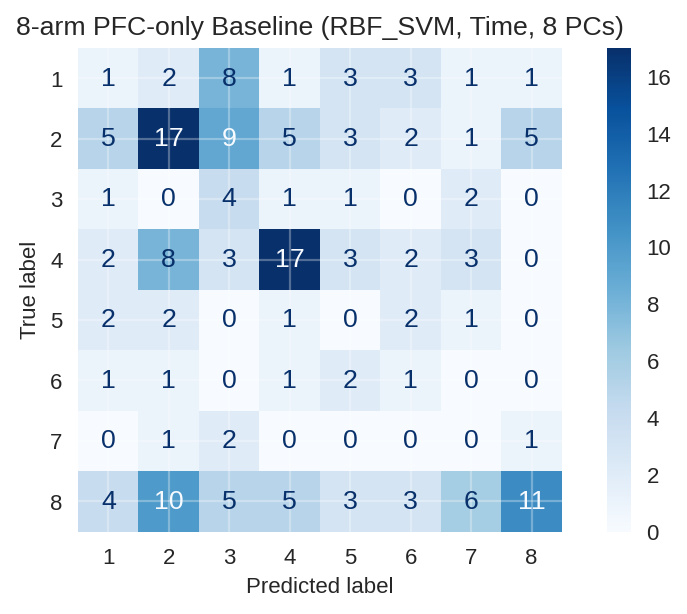

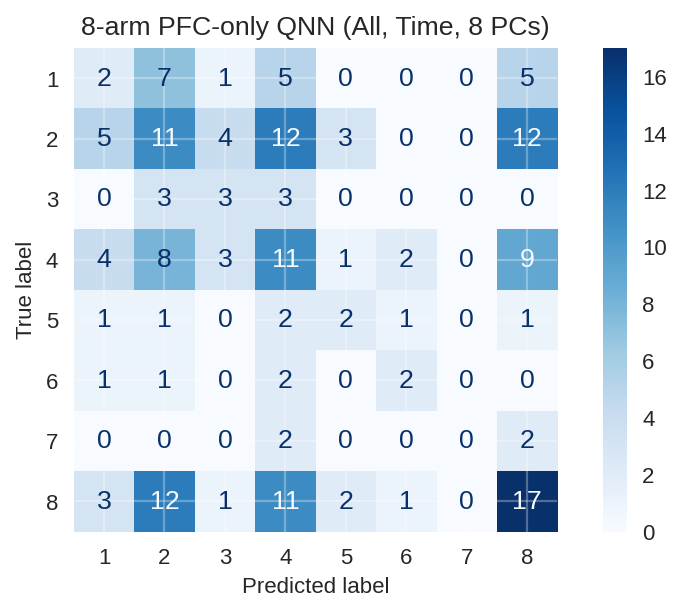

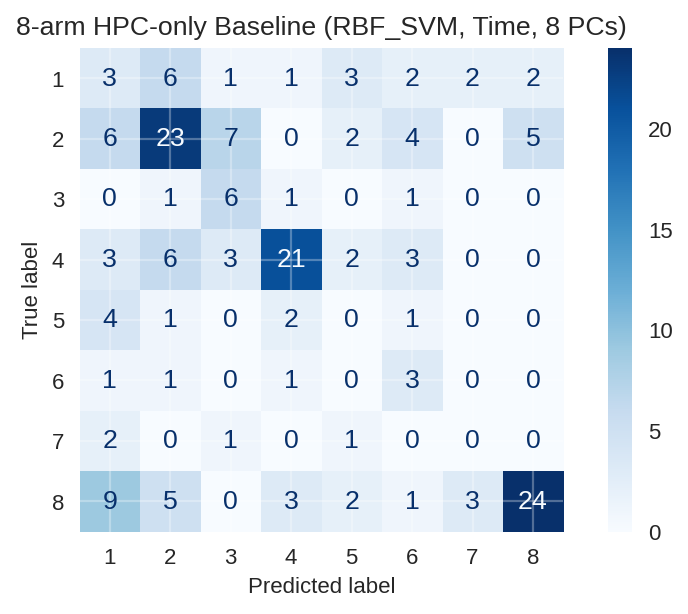

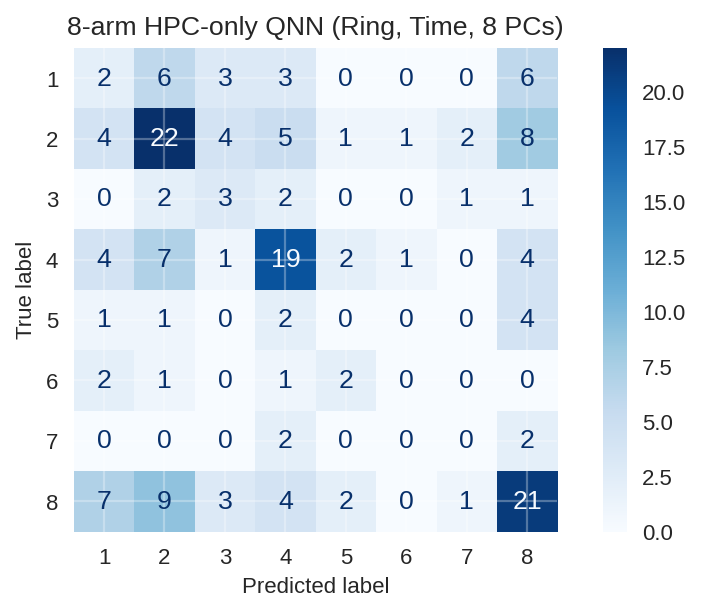

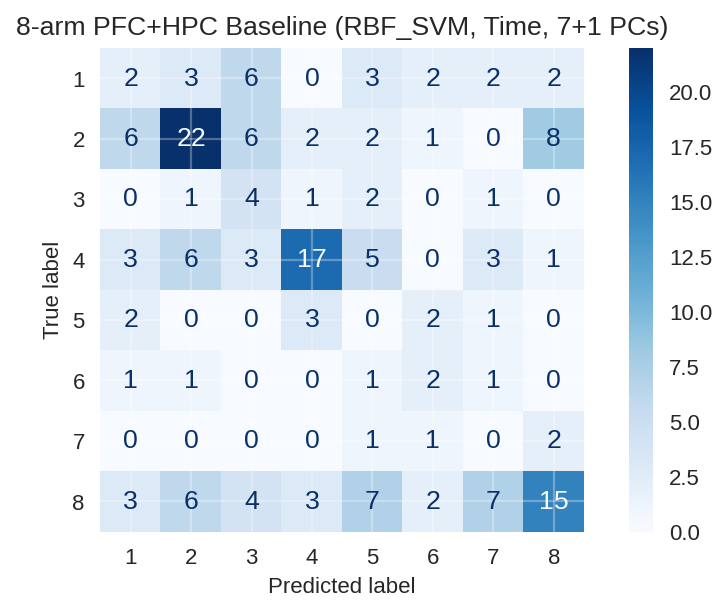

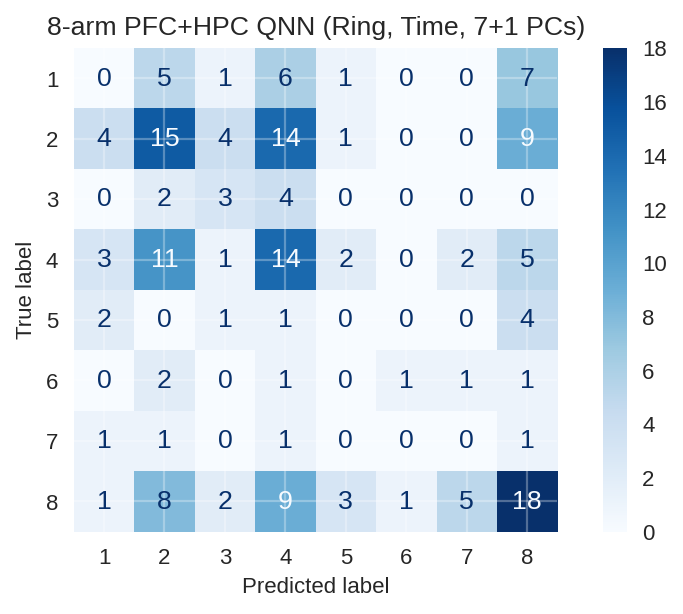

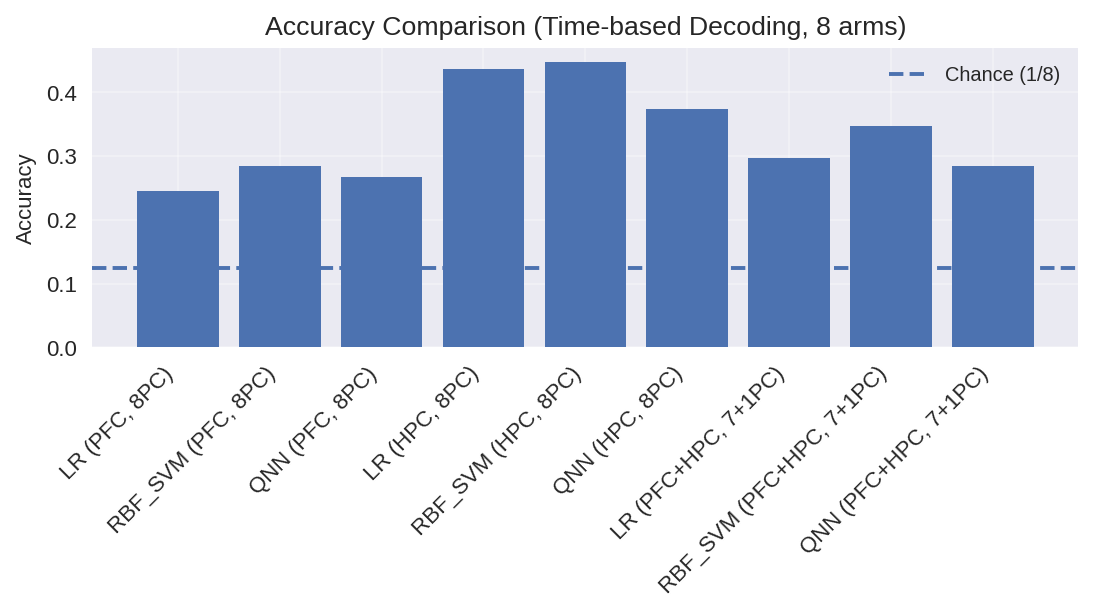

In [93]:
# --------------------------------- MAIN (8 arms, *_all) ---------------------------------

# 1) Load ALL dataset from pickle file
file_path = "qnn_data_pre.pkl"
with open(file_path, "rb") as f:
    data = pickle.load(f)

tensor_pfc_all    = data["pre_tensor_pfc_all"]
tensor_hpc_all    = data["pre_tensor_hpc_all"]
event_arm_ids_all = np.array(data["pre_event_arm_ids_all"])
trial_ids_all     = np.array(data["pre_trial_ids_all"])

# 2) Reorder to (neurons, time, events)
tensor_pfc_all = np.transpose(tensor_pfc_all, (1, 0, 2))
tensor_hpc_all = np.transpose(tensor_hpc_all, (1, 0, 2))

# 3) Convert tensors to per-event matrices and remap labels to 0..K-1 (K=8)
X_pfc_time = tensor_to_event_list(tensor_pfc_all)
X_hpc      = tensor_to_event_list(tensor_hpc_all)
y_raw      = event_arm_ids_all
groups     = trial_ids_all
classes_k  = sorted(np.unique(y_raw))           # original class IDs (8 arms)
y_k        = map_classes_to_012(y_raw, classes_k)
n_classes  = len(classes_k)

# 4) Run experiments (quiet) and collect a single final results table
results = []

# ---- Classical baselines: PFC only (8 PCs)
res_pfc8, preds_pfc8 = eval_baselines_all(X_pfc_time, None, y_k, n_pcs_pfc=8, n_pcs_hpc=0,
    n_splits=3, random_state=42, task_name="8arm-PFC-8PC-Time", groups=groups)

for name, metrics in res_pfc8.items():
    results.append({'Input': 'Time-based PFC', 'Model': f'{name} (Classical)', 'Architecture': 'N/A',
        'n_PCs_PFC': 8, 'n_PCs_HPC': 0,
        'ACC': metrics['acc'], 'ACC_sd': metrics['acc_sd'],
        'F1': metrics['f1'], 'F1_sd': metrics['f1_sd'],
        'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# ---- Classical baselines: HPC only (8 PCs)
res_hpc8, preds_hpc8 = eval_baselines_all(None, X_hpc, y_k, n_pcs_pfc=0, n_pcs_hpc=8,
    n_splits=3, random_state=42, task_name="8arm-HPC-8PC-Time", groups=groups)

for name, metrics in res_hpc8.items():
    results.append({'Input': 'Time-based HPC', 'Model': f'{name} (Classical)', 'Architecture': 'N/A',
        'n_PCs_PFC': 0, 'n_PCs_HPC': 8,
        'ACC': metrics['acc'], 'ACC_sd': metrics['acc_sd'],
        'F1': metrics['f1'], 'F1_sd': metrics['f1_sd'],
        'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# ---- Classical baselines: Fusion PFC+HPC (7+1 PCs = total 8)
res_fus8, preds_fus8 = eval_baselines_all(X_pfc_time, X_hpc, y_k, n_pcs_pfc=7, n_pcs_hpc=1,
    n_splits=3, random_state=42, task_name="8arm-Fusion-7+1-Time", groups=groups)

for name, metrics in res_fus8.items():
    results.append({'Input': 'Time-based PFC + HPC', 'Model': f'{name} (Classical)', 'Architecture': 'N/A',
        'n_PCs_PFC': 7, 'n_PCs_HPC': 1,
        'ACC': metrics['acc'], 'ACC_sd': metrics['acc_sd'],
        'F1': metrics['f1'], 'F1_sd': metrics['f1_sd'],
        'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# ---- QNN: PFC only (8 PCs = 8 qubits), topology "all"
q8_pfc, (yT_pfc, yP_pfc) = run_qnn_all(X_pfc_time, None, y_k, n_pcs_pfc=8, n_pcs_hpc=0, groups=groups,
    topology="all", n_splits=3, task_name="8arm-PFC-Time", n_layers=8)

results.append({'Input': 'Time-based PFC', 'Model': 'QNN', 'Architecture': 'All topology, 8 layers, 8 qubits',
    'n_PCs_PFC': 8, 'n_PCs_HPC': 0,
    'ACC': q8_pfc['acc'], 'ACC_sd': q8_pfc['acc_sd'],
    'F1': q8_pfc['f1'], 'F1_sd': q8_pfc['f1_sd'],
    'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# ---- QNN: HPC only (8 PCs = 8 qubits), topology "ring"
q8_hpc, (yT_hpc, yP_hpc) = run_qnn_all(None, X_hpc, y_k, n_pcs_pfc=0, n_pcs_hpc=8, groups=groups,
    topology="ring", n_splits=3, task_name="8arm-HPC-Time", n_layers=6)

results.append({'Input': 'Time-based HPC', 'Model': 'QNN', 'Architecture': 'Ring topology, 6 layers, 8 qubits',
    'n_PCs_PFC': 0, 'n_PCs_HPC': 8, 'ACC': q8_hpc['acc'], 'ACC_sd': q8_hpc['acc_sd'],
    'F1': q8_hpc['f1'], 'F1_sd': q8_hpc['f1_sd'],
    'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# ---- QNN: Fusion PFC+HPC (7+1 qubits = 8), topology "ring"
q8_fus, (yT_fus, yP_fus) = run_qnn_all(
    X_pfc_time, X_hpc, y_k, n_pcs_pfc=7, n_pcs_hpc=1, groups=groups,
    topology="ring", n_splits=3, task_name="8arm-Fusion-Time", n_layers=6
)
results.append({'Input': 'Time-based PFC + HPC', 'Model': 'QNN', 'Architecture': 'Ring topology, 6 layers, 8 qubits',
    'n_PCs_PFC': 7, 'n_PCs_HPC': 1,
    'ACC': q8_fus['acc'], 'ACC_sd': q8_fus['acc_sd'],'F1': q8_fus['f1'], 'F1_sd': q8_fus['f1_sd'],
    'Perm_p': None, 'CI_ACC_low': None, 'CI_ACC_high': None})

# ---- Bootstrap CIs for the QNN rows only (kept quiet)
ci_acc_low_pfc, ci_acc_high_pfc = bootstrap_ci_metric(yT_pfc, yP_pfc, accuracy_score)
ci_acc_low_hpc, ci_acc_high_hpc = bootstrap_ci_metric(yT_hpc, yP_hpc, accuracy_score)
ci_acc_low_fus, ci_acc_high_fus = bootstrap_ci_metric(yT_fus, yP_fus, accuracy_score)
for row in results:
    if row['Model'] == 'QNN' and row['Input'] == 'Time-based PFC':
        row['CI_ACC_low'] = ci_acc_low_pfc; row['CI_ACC_high'] = ci_acc_high_pfc
    if row['Model'] == 'QNN' and row['Input'] == 'Time-based HPC':
        row['CI_ACC_low'] = ci_acc_low_hpc; row['CI_ACC_high'] = ci_acc_high_hpc
    if row['Model'] == 'QNN' and row['Input'] == 'Time-based PFC + HPC':
        row['CI_ACC_low'] = ci_acc_low_fus; row['CI_ACC_high'] = ci_acc_high_fus

# 5) FINAL TABLE (only print once)
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# 6) COMPACT PLOTS (no extra prints)
cm_pfc_base = preds_pfc8["RBF_SVM"]
plot_confmat_all(cm_pfc_base[0], cm_pfc_base[1], title="8-arm PFC-only Baseline (RBF_SVM, Time, 8 PCs)", labels=classes_k)

plot_confmat_all(yT_pfc, yP_pfc, title="8-arm PFC-only QNN (All, Time, 8 PCs)", labels=classes_k)

cm_hpc_base = preds_hpc8["RBF_SVM"]
plot_confmat_all(cm_hpc_base[0], cm_hpc_base[1], title="8-arm HPC-only Baseline (RBF_SVM, Time, 8 PCs)", labels=classes_k)

plot_confmat_all(yT_hpc, yP_hpc, title="8-arm HPC-only QNN (Ring, Time, 8 PCs)", labels=classes_k)

cm_fus_base = preds_fus8["RBF_SVM"]
plot_confmat_all(cm_fus_base[0], cm_fus_base[1], title="8-arm PFC+HPC Baseline (RBF_SVM, Time, 7+1 PCs)", labels=classes_k)

plot_confmat_all(yT_fus, yP_fus, title="8-arm PFC+HPC QNN (Ring, Time, 7+1 PCs)", labels=classes_k)

acc_dict = {'LR (PFC, 8PC)': res_pfc8['LR']['acc'],
    'RBF_SVM (PFC, 8PC)': res_pfc8['RBF_SVM']['acc'],
    'QNN (PFC, 8PC)': q8_pfc['acc'],
    'LR (HPC, 8PC)': res_hpc8['LR']['acc'],
    'RBF_SVM (HPC, 8PC)': res_hpc8['RBF_SVM']['acc'],
    'QNN (HPC, 8PC)': q8_hpc['acc'],
    'LR (PFC+HPC, 7+1PC)': res_fus8['LR']['acc'],
    'RBF_SVM (PFC+HPC, 7+1PC)': res_fus8['RBF_SVM']['acc'],
    'QNN (PFC+HPC, 7+1PC)': q8_fus['acc'],}

plot_accuracy_comparison_all(acc_dict, title="Accuracy Comparison (Time-based Decoding, 8 arms)", n_classes=n_classes)